# Учебный проект 13_Прогнозирование температуры звезды

## Содержание

* [Описание проекта](#Описание)
* [Импорт библиотек Python](#Импорт)
* [Загрузка данных](#Загрузка)
* [Предобработка данных](#Предобработка)
* [Исследовательский анализ данных](#Исследование)
    * [Анализ категорильных показателей](#Исследование_качество)
    * [Анализ количественных показателей](#Исследование_количество)
* [Корреляционный анализ данных](#Корреляция)
* [Построение моделей машинного обучения](#Моделирование)
    * [Подготовка данных](#Моделирование_подготовка)
    * [Построение baseline-модели прогнозирования на базе нейронной сети](#Моделирование_baseline)
    * [Построение улучшенной модели нейронной сети](#Моделирование_улучшение)
        * [Перебор гиперпараметров модели нейронной сети с помощью библиотеки Optuna](#Моделирование_улучшение_перебор)
        * [Изменение размера батчей](#Моделирование_улучшение_батчи)
        * [Метод Batch Normalization](#Моделирование_улучшение_BatchNorm)
        * [Метод Dropout](#Моделирование_улучшение_dropout)
* [Общий вывод](#Вывод)

## Описание проекта <a class = 'anchor' id = 'Описание'></a>

На исследовании находятся данные с `показателями космических объектов, - звезд` - которые были предоставлены руководством компании "Небо на ладони".

---

`Задача`

Разработать модель нейронной сети для **прогнозирования температуры на поверхности звезды**.

---

`Путь решения`

1. Собрать данные с характеристиками звезд;
2. Провести предобработку значений в наборах данных;
3. Провести исследовательский анализ данных для выявления закономерностей, применимых к последующей настройке модели нейронной сети;
4. Подготовить выборки для обучения моделей;
5. Построить baseline модели нейронной сети для получения предварительных результатов;
6. Подготовить улучшенную версию нейронной сети с перебором следующих параметров:
    * Dropout;
    * BatchNormalization;
    * Размер батча.
7. Сформировать вывод о подготовленных решениях. Выполнить сравнение двух версий модели нейронной сети.

---

`Располагаемые данные`

**Данные, описывающие показатели звезд**

* Относительная светимость L/Lo - светимость звезды относительно Солнца;
* Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца;
* Абсолютная звездная величина Mv — физическая величина, характеризующая блеск звезды;
* Звездный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа;
* Тип звезды:

|Тип звезды|Номер, соответствующий типу|
|----------|---------------------------|
|Коричневый карлик|0|
|Красный карлик|1|
|Белый карлик|2|
|Звезды главной последовательности|3|
|Сверхгигант|4|
|Гипергигант|5|

**Целевой признак**
* Абсолютная температура Т(К) - температура поверхности звезды в Кельвинах.

**Справочная информация**
* Светимость Солнца (Lo) = 3.828 * 10**26;
* Радиус Солнца (Ro) = 6.9551 * 10**8.

## Импорт библиотек Python <a class = 'anchor' id = 'Импорт'></a>

1. Импорт библиотек Python:
    * для манипулирования данными;
    * для визуализации данных;
    * для решения задач машинного обучения:
        * механизмы построения нейронных сетей;
        * метрики оценки эффективности моделей;
        * механизмы отбора данных;
        * механизмы подготовки данных.
2. Инициализация переменных-констант для последующего использования на этапе построения моделей МО;
3. Формирование вывода по итогам данного этапа.

In [1]:
# импорт библиотек python

# для манипулирования данными
import pandas as pd
import numpy as np

# для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

# установка размеров для последующих графиков в проекте
plt.rcParams['figure.figsize'] = (10, 5)

# библиотека математических операций
import math
# библиотека для работы с датой и временем
import datetime as dt

# вычисление корреляции данных
from phik import phik_matrix

# импорт библиотеки для построения нейронной сети
import torch
import torch.nn as nn

# метрики оценки эффективности моделей
from sklearn.metrics import (mean_squared_error, 
                            root_mean_squared_error)

# механизмы отбора данных и подбора параметров моделей
from sklearn.model_selection import train_test_split
import optuna
from optuna.samplers import TPESampler

# механизмы подготовки данных
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder,
                                   OrdinalEncoder)

In [2]:
# инициализация констант для дальнейшего использования в проекте
# инициализация переменной RANDOM_STATE для фиксирования "случайности"
RANDOM_STATE = 42
# инициализация переменной TEST_SIZE для разделения выборки на обучающую и тестовую
TEST_SIZE = 0.25

**Вывод**

1. Импортированы библиотеки Python:
    * для манипулирования данными:
        * pandas;
        * numpy.
    * для визуализации данных:
        * matplotlib.pyplot;
        * seaborn;
        * plotly;
        * dash.
    * для вычисления корреляции данных:
        * phik_matrix.
    * для решения задач машинного обучения:
        * механизмы построения нейронной сети:
            * torch.nn.
        * метрики оценки эффективности моделей классификации;
        * train_test_split - механизм разделения данных;
        * StandardScaler - стандартизация данных;
        * OneHotEncoder - one-hot кодирование категориальных признаков;
        * OrdinalEncoder - кодирование значений ранговых признаков.
2. Инициализированы переменные **RANDOM_STATE** и **TEST_SIZE** для фиксирования "случайности" и размера тестовой выборки.

## Загрузка данных <a class = 'anchor' id = 'Загрузка'></a>

Данный блок характеризуется следующими последовательными действиями:

1. Загрузка данных в рабочую среду Jupyter Notebook. Инициализация переменной **stars**;
2. Вывод на экран параметров датасетов:
    * вывод общей структуры набора данных - демонстрация первых 5 строк;
    * общей информации о наборе данных;
    * визуализация распределений количественных показателей.
3. Формирование вывода по итогам данного этапа.

In [3]:
# загрузка данных в рабочую среду

try:
    stars = pd.read_csv('~/Desktop/YandexPraktikum_projects/datasets/6_class.csv')
except:
    stars = pd.read_csv('/datasets/6_class.csv')

In [4]:
# инициализация пользовательской функции для первичного изучения содержимого наборов данных
def first_meeting (df : pd.DataFrame, df_name : str) -> None:
    print(f'Структура набора данных {df_name}')
    display(df.head())
    print('Общая информация о наборе')
    print(df.info())
    print()

In [5]:
# инициализация пользовательской функции построения распределений количественных непрерывных показателей
def num_distribution(df : pd.DataFrame, column : str, bins : int):
    plt.subplot(1, 2, 1)
    plt.xlabel(f'Значения признака {column}')
    plt.ylabel(f'Частота значений признака')
    plt.title(f'Гистограмма значений {column}', fontsize = 10)
    sns.histplot(df, x = column, bins = bins)
    plt.subplot(1, 2, 2)
    plt.xlabel(f'Значения признака {column}')
    plt.title(f'Диаграмма размаха значений {column}', fontsize = 10)
    sns.boxplot(df, x = column)
    plt.grid(False)
    plt.show()

In [6]:
# инициализация пользовательской функции построения диаграмм количественных дискретных показателей
def num_countplot(df : pd.DataFrame, column : str):
    sns.countplot(df, x = column)
    plt.title(f'Столбчатая диаграмма значений признака {column}', fontsize = 12)
    plt.xlabel(f'Признак {column}')
    plt.xticks(rotation = 45)
    plt.ylabel(f'Количество значений признака')
    plt.show()

Структура набора данных stars


,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Red,M
1,3042,0.000500,0.1542,16.60,0,Red,M
2,2600,0.000300,0.1020,18.70,0,Red,M
3,2800,0.000200,0.1600,16.65,0,Red,M
4,1939,0.000138,0.1030,20.06,0,Red,M


Общая информация о наборе
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
 6   Spectral Class          240 non-null    object 
dtypes: float64(3), int64(2), object(2)
memory usage: 13.3+ KB
None



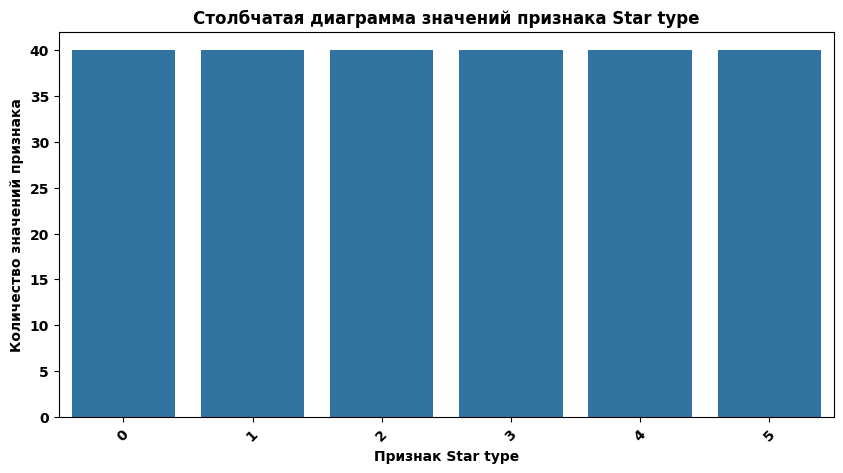

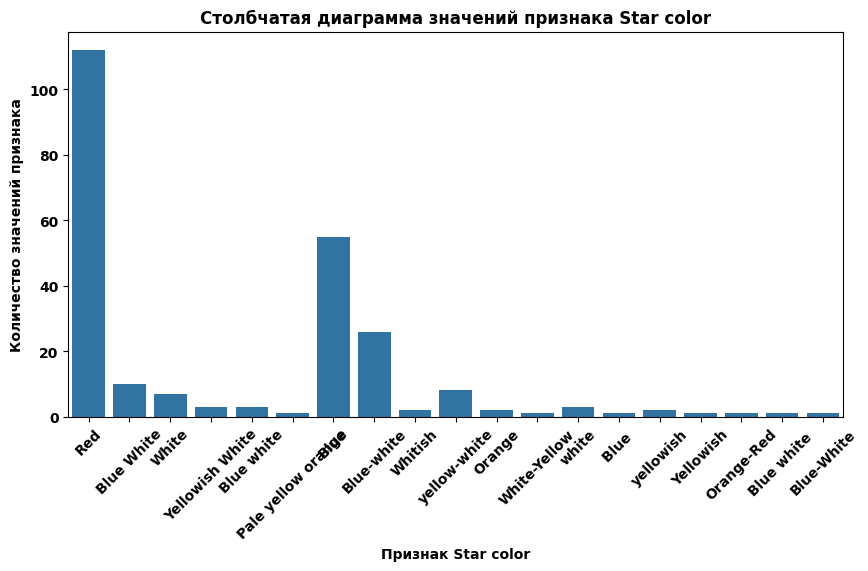

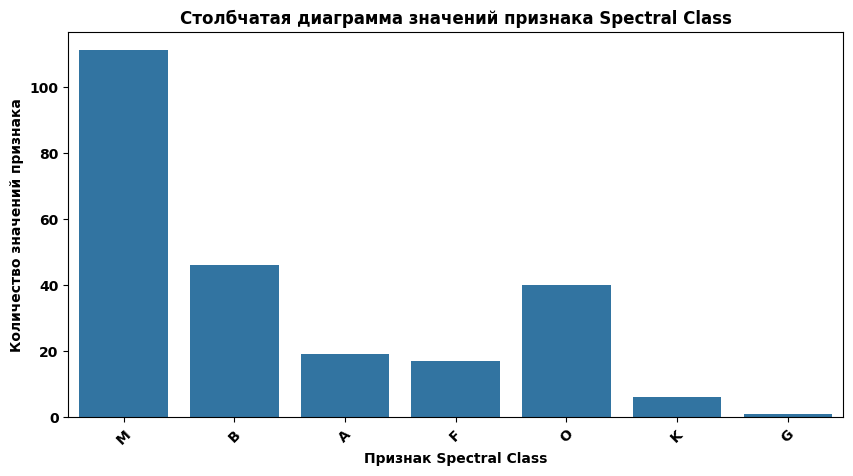

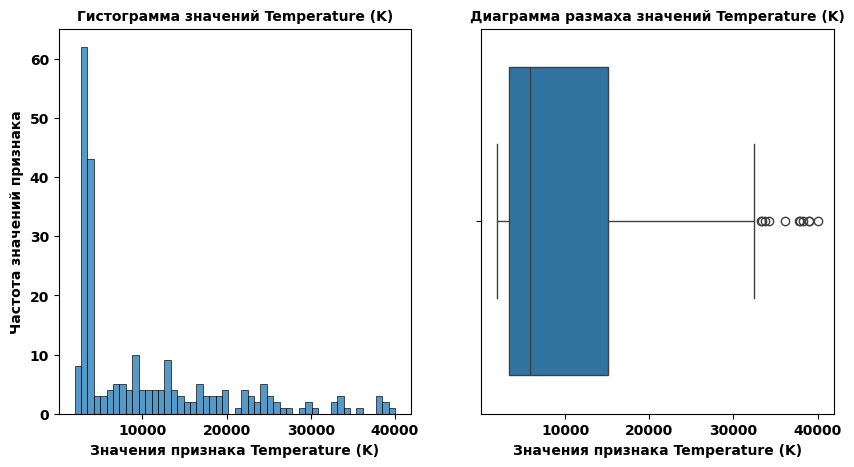

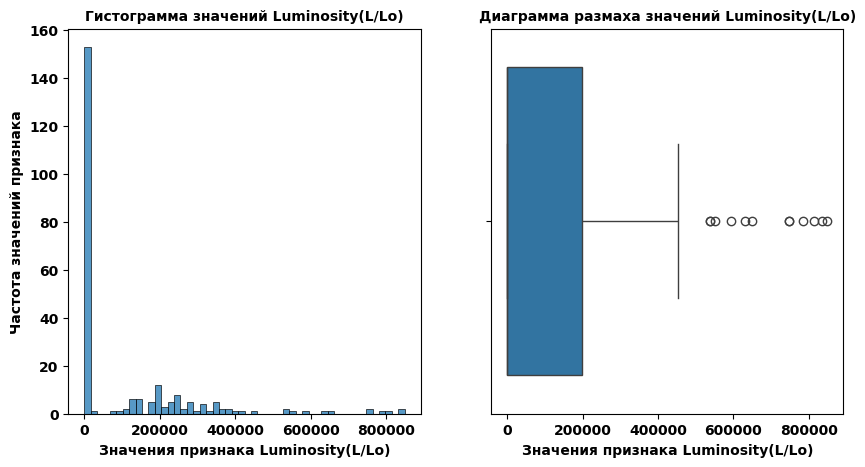

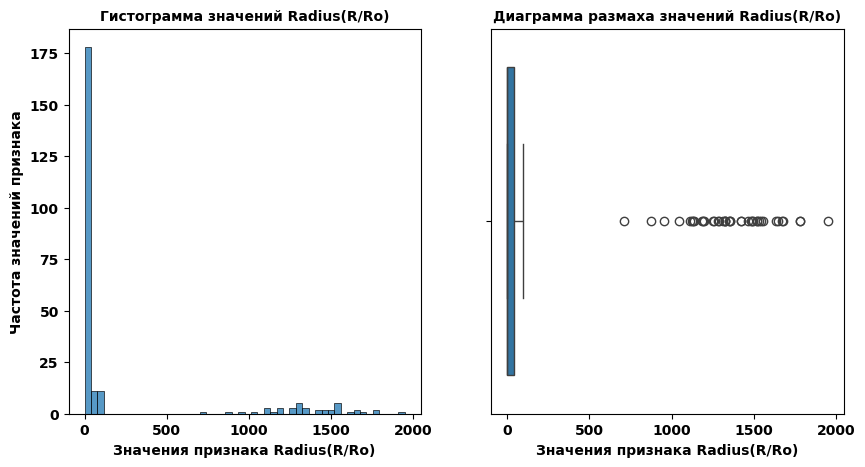

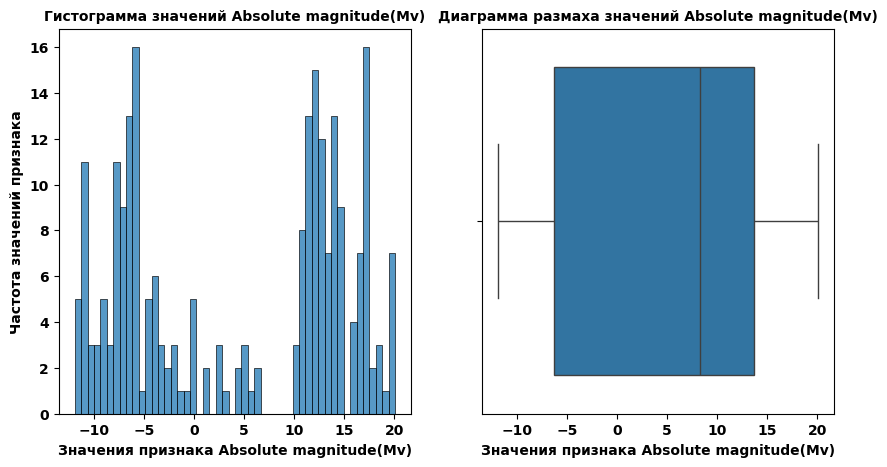

In [7]:
# вывод на экран параметров датасета 'autos'
first_meeting(stars, 'stars')

# вывод на экран графиков дискретных величин по набору 'autos'
for col in ['Star type', 'Star color', 'Spectral Class']:
    num_countplot(stars, col)

# вывод на экран графиков непрерывных количественных величин по набору 'autos'
for col in ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']:
    num_distribution(stars, col, 50)

**Вывод**

1. Произведена загрузка данных в рабочую среду Jupyter Notebook. Инициализирована переменная **stars**;
2. Выведены на экран параметры датасета:
    * В наборе данных **отсутствуют пустые значения** по признакам;
    * Типы данных **соответствуют сущностям значений** по всем рассматриваемым признакам;
    * Названия столбцов **необходимо привести к формату snake_case**;
    * Наблюдаются неявные дубликаты по признаку **Star color**;
    * Наблюдаются выбросы по количественным признакам:
        * **Temperature (K)**;
        * **Luminosity (L/Lo)**;
        * **Radius (R/Ro)**.
    * Самые популярные категории по спектральному классу: **M, B** и **O**;
    * Самые популярные цвета звезд: **Red**, **Pale yellow orange** и **Blue**.

## Предобработка данных <a class = 'anchor' id = 'Предобработка'></a>

Данный блок характеризуется следующими последовательными действиями:

1. Приведение названий столбцов к формату snake_case;
2. Обработка неявных дубликатов - значений - по признаку **Star color**;
3. Проверка датасетов на явные дубликаты;
4. Формирование вывода по итогам данного этапа.

In [8]:
# преобразование названий столбцов к формату snake_case
stars.columns = ['_'.join(col.lower().split(' ')) for col in stars.columns]

stars = stars.rename(columns = {
    'temperature_(k)':'temperature',
    'luminosity(l/lo)':'luminosity',
    'radius(r/ro)':'radius',
    'absolute_magnitude(mv)':'absolute_magnitude'
})

In [9]:
# преобразование значений по признаку 'star_color'
stars['star_color'] = (
    stars['star_color']
    .str.lower() # понижение регистра
    .str.strip() # исключение пробелов с конца строк
    .str.replace(' ', '-') # замена знака разделителя
)

# замена значений с перестановкой цвета
for color in ['yellow-white', 'yellowish-white']:
    stars.loc[stars['star_color'] == color, 'star_color'] = 'white-yellow'

stars.loc[stars['star_color'] == 'whitish', 'star_color'] = 'white'
stars.loc[stars['star_color'] == 'orange-red', 'star_color'] = 'orange'
stars.loc[stars['star_color'] == 'pale-yellow-orange', 'star_color'] = 'orange'

In [10]:
# проверка датасета на явные дубликаты
print('Количество явных дубликатов в наборе данных:', stars.duplicated().sum())
print('Доля дубликатов от общего количества записей в наборе: {:.1%}'.format(stars.duplicated().sum() / stars.shape[0]))

Количество явных дубликатов в наборе данных: 0
Доля дубликатов от общего количества записей в наборе: 0.0%


**Вывод**

1. Названия столбцов приведены к формату snake_case;
2. Обработаны неявные дубликаты - значения - по признаку **Star color**:
    * Понижен регистр значений;
    * Удалены пробелы в конце строк;
    * Заменены пробелы на дефис;
    * Заменены значения с перестановкой цвета.
3. Проверка датасетов на явные дубликаты - **Явные дубликаты отсутствуют**;
4. Набор данных подготовлен к дальнейшему исследовательскому анализу.

## Исследовательский анализ данных <a class = 'anchor' id = 'Исследование'></a>

Данный блок характеризуется следующими последовательными действиями:

1. Вывод на экран основной статистической информации по текущим версиям наборов данных;
2. Исследование соотношения количества значений качественных показателей;
3. Исследование распределения количественных показателей наборов. Построение **гистограмм распределения значений**;
4. Формирование вывода по итогам этапа.

In [11]:
# вывод на экран основных статистик по набору 'data'
print(f'Основная статистическая информация по набору data')
stars.describe(include = 'number')

Основная статистическая информация по набору data


,temperature,luminosity,radius,absolute_magnitude,star_type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


**Вывод по промежуточному этапу**

Набор `stars` характеризуется следующими статистическими показателями:

* **temperature - температура звезды в Кельвинах**:
    * Среднее значение - 10 497.5;
    * Минимальное значение - 1 939.0;
    * Максимальное значение - 40 000.0;
    * Стандартное отклонение - 9 552.4.
* **luminosity - относительная светимость**:
    * Среднее значение - 107 188.4;
    * Минимальное значение - 0.0;
    * Максимальное значение - 849 420.0.
    * Стандартное отклонение - 179 432.2.
* **radius - относительный радиус**:
    * Среднее значение - 237.2;
    * Минимальное значение - 0.0084;
    * Максимальное значение - 1 948.5;
    * Стандартное отклонение - 517.2.
* **absolute_magnitude - абсолютная звездная величина**:
    * Среднее значение - 4.4;
    * Минимальное значение - -11.9;
    * Максимальное значение - 20.1;
    * Стандартное отклонение - 10.5.

In [12]:
# инициализация пользовательской функции по формированию вывода информации

def display_info(df: pd.DataFrame, column_name: str, title: str, xlabel: str, kind_of_plot : str):
# построение визуализации по выбранной метрике
    plt.title(title, fontsize = 12)
    if kind_of_plot == 'pie':
        (df[column_name]
         .value_counts()
         .sort_values(ascending=True)
         .plot(kind = kind_of_plot, figsize = (8, 5), autopct='%1.0f%%'))
    else:
        (df[column_name]
         .value_counts()
         .sort_values(ascending=True)
         .plot(kind = kind_of_plot, figsize = (8, 5)))
    ax = plt.gca()
    ax.axes.yaxis.set_visible(False)
    plt.xlabel(xlabel)
    plt.show()

# построение сводной таблицы по выбранной метрике
    pivot_data = (df[column_name]
                  .value_counts()
                  .sort_values(ascending=False)
                  .to_frame())
    pivot_data['share_of_stars'] = round(pivot_data['count'] / pivot_data['count'].sum() * 100, 2)
    pivot_data.columns = ['count_of_stars', 'share_of_stars']
    display(pivot_data)

In [13]:
# инициализация пользовательской функции по построению гистограмм по передаваемым метрикам
def histogram_plotting(data: pd.DataFrame, feature : str, bins: int, x_size: int, y_size: int, feature_xlabel : str):
    # вычисление статистических метрик для дальнейшей визуализации
    q1 = data[feature].quantile(0.25)
    q3 = data[feature].quantile(0.75)
    upper_bound = q3 + 1.5 * (q3 - q1)
    lower_bound = q1 - 1.5 * (q3 - q1)

    # построение визуализации
    plt.figure(figsize = (x_size, y_size))
    plt.hist(data[feature], color = 'blue', edgecolor = 'white', bins = bins)
    plt.axvline(upper_bound, c = 'red', ls = '-', label = 'верхняя граница допустимых значений')
    plt.axvline(q3, c = 'red', ls = '--', label = '3 квартиль значений')
    plt.axvline(q1, c = 'black', ls = '--', label = '1 квартиль значений')
    plt.axvline(lower_bound, c = 'black', ls = '-', label = 'нижняя граница допустимых значений')
    plt.title(f'Гистограмма распределения значений по метрике: {feature_xlabel}', fontsize = 10)
    plt.xlabel(feature_xlabel)
    plt.ylabel('Количество значений по метрике')
    plt.legend(bbox_to_anchor = (1, 0.6))
    plt.show()

    # вывод статистических метрик на экран
    print('Верхняя допустимая граница значений:', upper_bound)
    print('Нижняя допустимая граница значений:', lower_bound)
    print('Медианное значение:', data[feature].median())
    print('Среднее значение:', round(data[feature].mean(), 2))

    # расчет доли аномальных значений по метрике
    print('Доля значений, выходящих за верхнюю границу: {:.2%}'.format(data[data[feature] > upper_bound].shape[0] / data[feature].shape[0]))
    print('Доля значений, выходящих за нижнюю границу: {:.2%}'.format(data[data[feature] < lower_bound].shape[0] / data[feature].shape[0]))

### Анализ категориальных показателей <a class = 'anchor' id = 'Исследование_качество'></a>

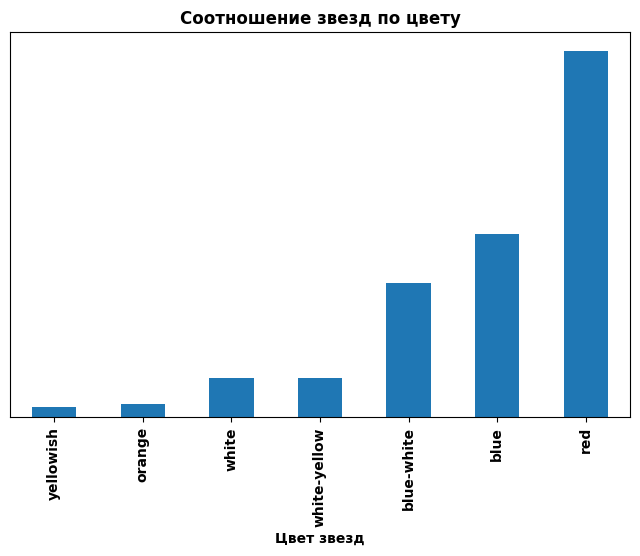

,count_of_stars,share_of_stars
star_color,,
red,112,46.67
blue,56,23.33
blue-white,41,17.08
white,12,5.00
white-yellow,12,5.00
orange,4,1.67
yellowish,3,1.25


In [14]:
# построение столбчатой диаграммы по соотношению звезд в зависимости от цвета
display_info(stars, 'star_color', 'Соотношение звезд по цвету', 'Цвет звезд', 'bar')

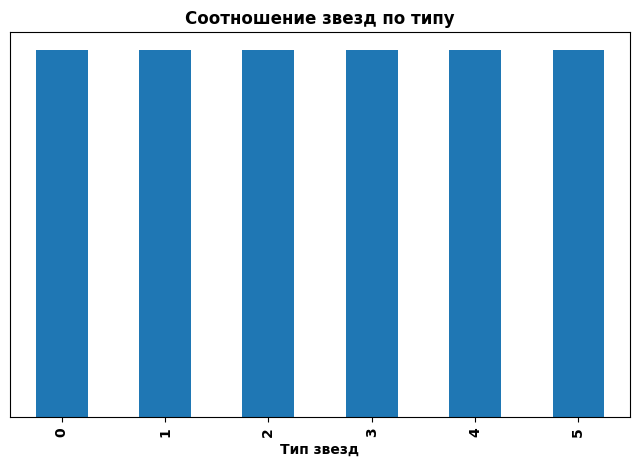

,count_of_stars,share_of_stars
star_type,,
0,40,16.67
1,40,16.67
2,40,16.67
3,40,16.67
4,40,16.67
5,40,16.67


In [15]:
# построение столбчатой диаграммы по соотношению звезд в зависимости от типа
display_info(stars, 'star_type', 'Соотношение звезд по типу', 'Тип звезд', 'bar')

**Вывод по промежуточному этапу**

* Большая часть звезд (87%) представлена тремя основными цветами: **red** (47%), **blue** (23%) и **blue-white** (17%);
* Все звезды распределены в равном отношении друг к другу: **40 представителей в каждом из 6 типов**.

### Анализ количественных показателей <a class = 'anchor' id = 'Исследование_количество'></a>

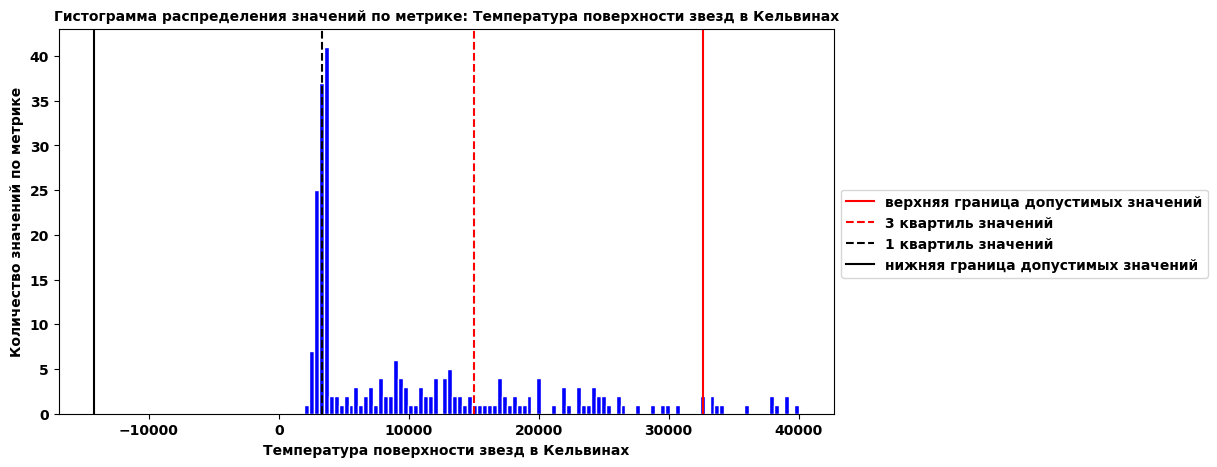

Верхняя допустимая граница значений: 32622.375
Нижняя допустимая граница значений: -14222.625
Медианное значение: 5776.0
Среднее значение: 10497.46
Доля значений, выходящих за верхнюю границу: 4.58%
Доля значений, выходящих за нижнюю границу: 0.00%


In [16]:
# построение  гистограммы распределения значений по признаку 'temperature'
histogram_plotting(stars, 'temperature', 100, 10, 5, 'Температура поверхности звезд в Кельвинах')

**Вывод по промежуточному этапу**

В наборе данных по рассматриваемому признаку - **temperature** - имеются аномально большие значения: **4.6%**
Вероятно, что подобные показатели принадлежат звездам главной последовательности, сверхгигантам и гипергигантам - в таком случае наблюдаемые значения не подлежат исключению.

In [17]:
# сводная таблица со средними температурами звезд в зависимости от типа
temp_pivot = stars.pivot_table(index = 'star_type', values = 'temperature', aggfunc = ['mean', 'median'])
temp_pivot.columns = ['temp_mean', 'temp_median']

temp_pivot.sort_values('temp_median', ascending = False)

,temp_mean,temp_median
star_type,,
2,13931.450,13380.0
4,15347.850,12821.0
3,16018.000,12560.5
5,11405.700,3766.0
1,3283.825,3314.0
0,2997.950,2935.0


In [18]:
# вывод уникальных типов звезд для аномально больших значений по признаку 'temperature'
print('Типы звезд с аномально большими значениями температуры:', 
      stars[stars['temperature'] > stars['temperature'].quantile(0.75) + 1.5 * (stars['temperature'].quantile(0.75) - stars['temperature'].quantile(0.25))]['star_type'].unique())

Типы звезд с аномально большими значениями температуры: [3 4 5]


**Вывод по промежуточному этапу**

По итогам анализа определено, что аномально **высокие температуры характерны для звезд типа 2, 3 и 4** (Белый карлик, Звезды главной последовательности и Сверхгиганты, соответственно).

**Наличие среди этих объектов звезды типа 5 - Сверхгигант - является уникальной ситуацией, но не подлежащей исключению из набора**.

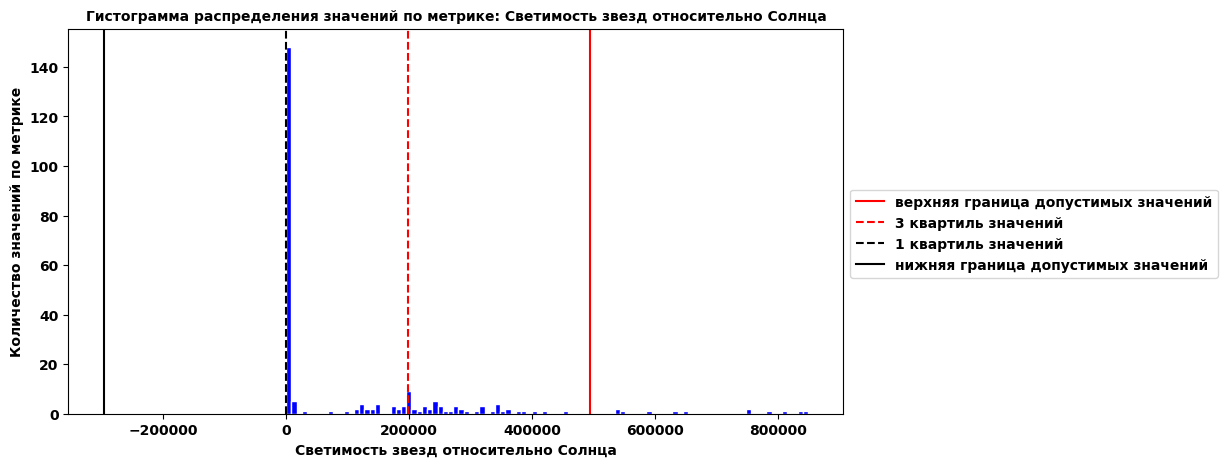

Верхняя допустимая граница значений: 495124.998702875
Нижняя допустимая граница значений: -297074.997838125
Медианное значение: 0.07050000000000001
Среднее значение: 107188.36
Доля значений, выходящих за верхнюю границу: 5.00%
Доля значений, выходящих за нижнюю границу: 0.00%


In [19]:
# построение  гистограммы распределения значений по признаку 'luminosity'
histogram_plotting(stars, 'luminosity', 100, 10, 5, 'Светимость звезд относительно Солнца')

**Вывод по промежуточному этапу**

Наблюдаются две обособленные от общей массы группы звезд, выходящие за верхнюю границу допустимых значений - 500 000
Необходимо изучить данные объекты для лучшего понимания природы такой картины.

In [20]:
# получение среза данных по объектам с аномально большой светимостью
max_luminosity = stars[stars['luminosity'] > stars['luminosity'].quantile(0.75) + 1.5 * (stars['luminosity'].quantile(0.75) - stars['luminosity'].quantile(0.25))]

# построение сводной таблицы по объектам с аномально большой светимостью
max_luminosity.groupby('star_type').agg({
    'temperature' : 'mean',
    'luminosity' : 'count'
})

,temperature,luminosity
star_type,,
4,21200.0,5
5,18548.0,7


**Вывод по промежуточному этапу**

Объекты с аномально большой светимостью относятся к типу 4 и 5 - **Сверхгиганты и Гипергиганты, соответственно**.

**Данные объекты не подлежат исключению из набора**.

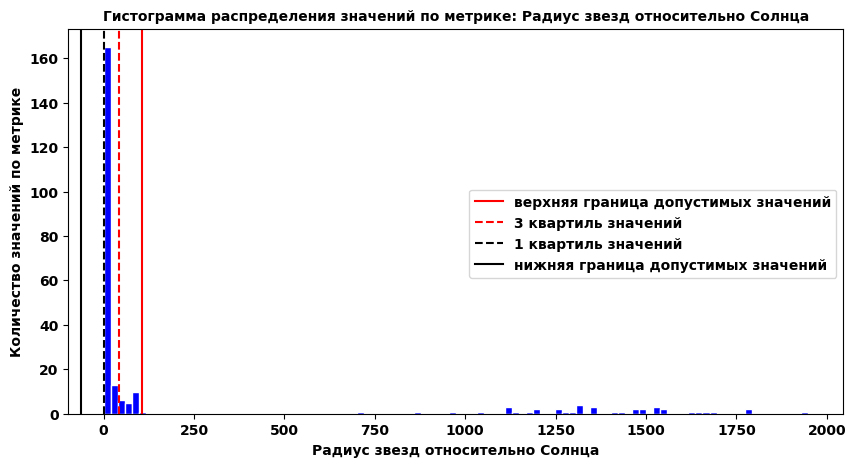

Верхняя допустимая граница значений: 106.720875
Нижняя допустимая граница значений: -63.868125
Медианное значение: 0.7625
Среднее значение: 237.16
Доля значений, выходящих за верхнюю границу: 16.67%
Доля значений, выходящих за нижнюю границу: 0.00%


In [21]:
# построение  гистограммы распределения значений по признаку 'radius'
histogram_plotting(stars, 'radius', 100, 10, 5, 'Радиус звезд относительно Солнца')

In [22]:
# получение среза данных по объектам с аномально большими радиусами относительно Солнца
max_radius = stars[stars['radius'] > stars['radius'].quantile(0.75) + 1.5 * (stars['radius'].quantile(0.75) - stars['radius'].quantile(0.25))]

# построение сводной таблицы по объектам с аномально большой светимостью
max_radius.groupby('star_type').agg({
    'temperature' : 'mean',
    'radius' : 'count'
})

,temperature,radius
star_type,,
5,11405.7,40


**Вывод по промежуточному этапу**

Объекты с аномально большими радиусами относительно Солнца относятся к типу 5 - **Гипергиганты**

**Данные объекты не подлежат исключению из набора**.

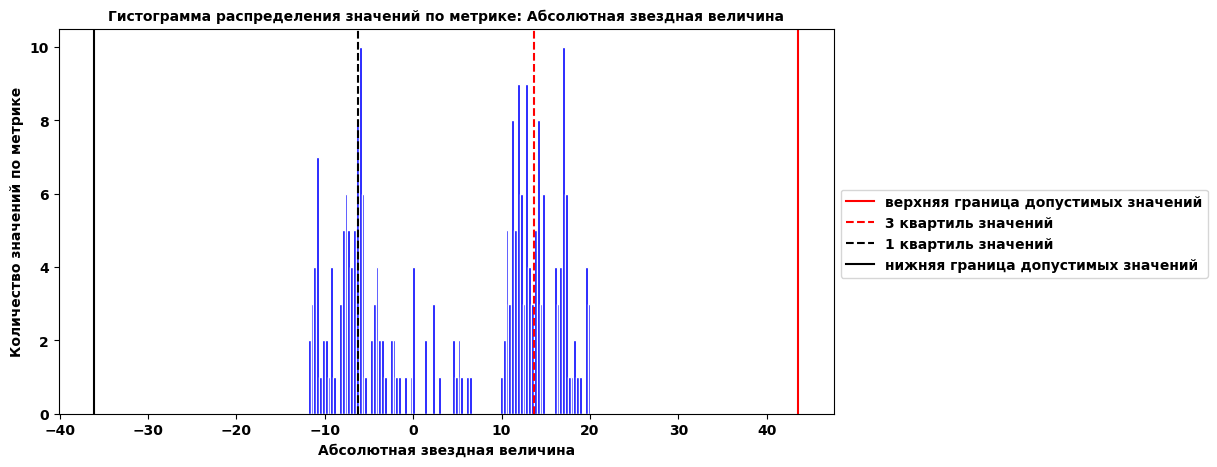

Верхняя допустимая граница значений: 43.5925
Нижняя допустимая граница значений: -36.1275
Медианное значение: 8.312999999999999
Среднее значение: 4.38
Доля значений, выходящих за верхнюю границу: 0.00%
Доля значений, выходящих за нижнюю границу: 0.00%


In [23]:
# построение  гистограммы распределения значений по признаку 'temperature'
histogram_plotting(stars, 'absolute_magnitude', 100, 10, 5, 'Абсолютная звездная величина')

**Вывод по промежуточному этапу**

Наблюдается **бимодальное распределение значений**, находящееся в пределах допустимых границ.

**Очистки набора данных от аномальных значений по данному признаку не требуется**

**Вывод**

**Вывод по промежуточному этапу**

1. Набор `stars` характеризуется следующими статистическими показателями:
    * **temperature - температура звезды в Кельвинах**:
        * Среднее значение - 10 497.5;
        * Минимальное значение - 1 939.0;
        * Максимальное значение - 40 000.0;
        * Стандартное отклонение - 9 552.4.
    * **luminosity - относительная светимость**:
        * Среднее значение - 107 188.4;
        * Минимальное значение - 0.0;
        * Максимальное значение - 849 420.0.
        * Стандартное отклонение - 179 432.2.
    * **radius - относительный радиус**:
        * Среднее значение - 237.2;
        * Минимальное значение - 0.0084;
        * Максимальное значение - 1 948.5;
        * Стандартное отклонение - 517.2.
    * **absolute_magnitude - абсолютная звездная величина**:
        * Среднее значение - 4.4;
        * Минимальное значение - -11.9;
        * Максимальное значение - 20.1;
        * Стандартное отклонение - 10.5.
2. Произведен анализ категориальных данных:
    * Большая часть звезд (87%) представлена тремя основными цветами: **red** (47%), **blue** (23%) и **blue-white** (17%);
    * Все звезды распределены в равном отношении друг к другу: **40 представителей в каждом из 6 типов**.
3. Проведен анализ количественных признаков:
    * Анализ признака **temperature**:
        * **Высокие температуры характерны для звезд типа 2, 3 и 4** (Белый карлик, Звезды главной последовательности и Сверхгиганты, соответственно);
        * **Наличие среди этих объектов звезды типа 5 - Сверхгигант - является уникальной ситуацией, но не подлежащей исключению из набора**.
    * Анализ признака **luminosity**:
        * Объекты с аномально большой светимостью относятся к типу 4 и 5 - **Сверхгиганты и Гипергиганты, соответственно**.
        * **Очистки набора данных от аномальных значений по данному признаку не требуется**.
    * Анализ признака **radius**:
        * Объекты с аномально большими радиусами относительно Солнца относятся к типу 5 - **Гипергиганты**;
        * **Очистки набора данных от аномальных значений по данному признаку не требуется**.
    * Анализ признака **absolute_magnitude**:
        * Наблюдается **бимодальное распределение значений**, находящееся в пределах допустимых границ.
        * **Очистки набора данных от аномальных значений по данному признаку не требуется**.
4. Набор данных подготовлен к дальнейшему использованию в проектировании нейросети.

## Корреляционный анализ данных <a class = 'anchor' id = 'Корреляция'></a>

Данный блок характеризуется следующими последовательными действиями:

1. Построение матрицы корреляции - поиск признаков высокой взаимосвязи показателей объектов;
2. Проведение отбора признаков для последующего построения моделей машинного обучения;
3. Построение диаграмм рассеяния для визуализации взаимосвязей между признаками и целевой переменной;
4. Формирование вывода по итогам данного этапа.

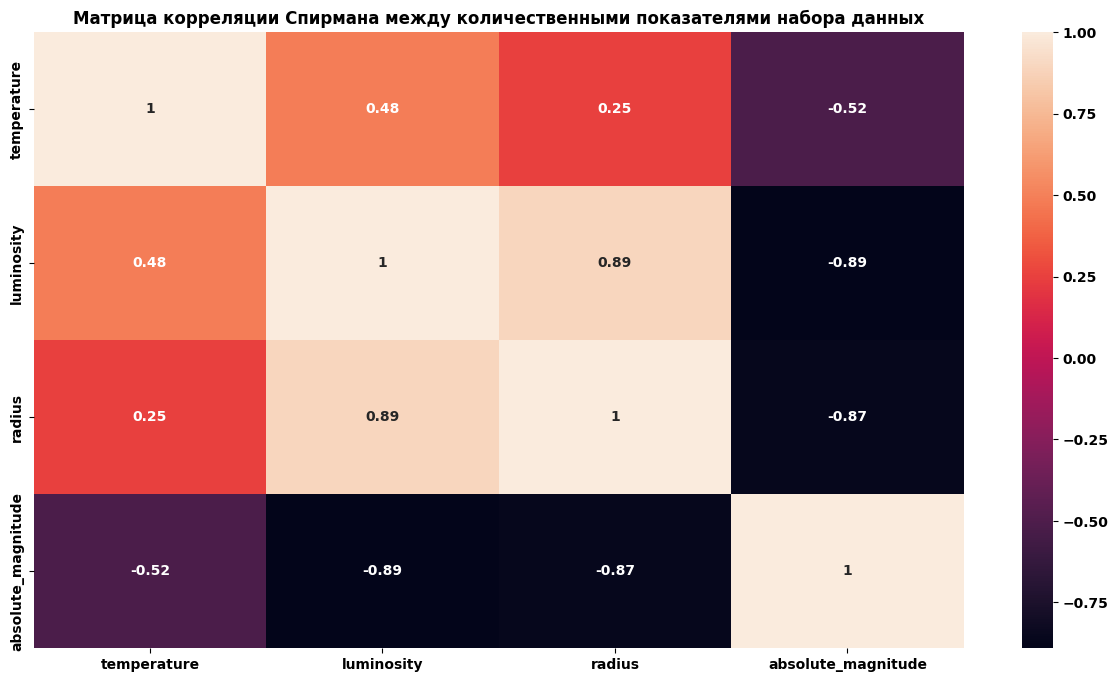

In [24]:
# построение матрицы корреляции и поиск сильных взаимосвязей
plt.figure(figsize=(15, 8))
sns.heatmap(stars.select_dtypes(include = 'number').drop('star_type', axis = 1).corr(method = 'spearman'), annot = True) # используется построение корреляции по Спирману, так как количественные значения не распределены нормально
plt.title('Матрица корреляции Спирмана между количественными показателями набора данных', fontsize = 12)
plt.show()

**Вывод по промежуточному этапу:**

Заметна линейная взаимосвязь (при анализе количественных показателей):
* между признаками и целевой переменной **temperature**:
    * **luminosity** - в большинстве случаев чем выше светимость звезды, тем выше температура;
    * **radius** - в большинстве случаев чем больше радиус, тем выше температура;
* между признаками:
    * **luminosity** и **radius** - чем больше радиус, тем больше светимость;
    * Взаимосвязь с признаком **absolute_magnitude** необходимо рассмотреть на корреляционной диграмме с учетом непрерывности значений по признаку, а также в связи с категориальными данными.

Требуется также рассмотреть взаимосвязь данных в **контексте учета категориальных показателей**.

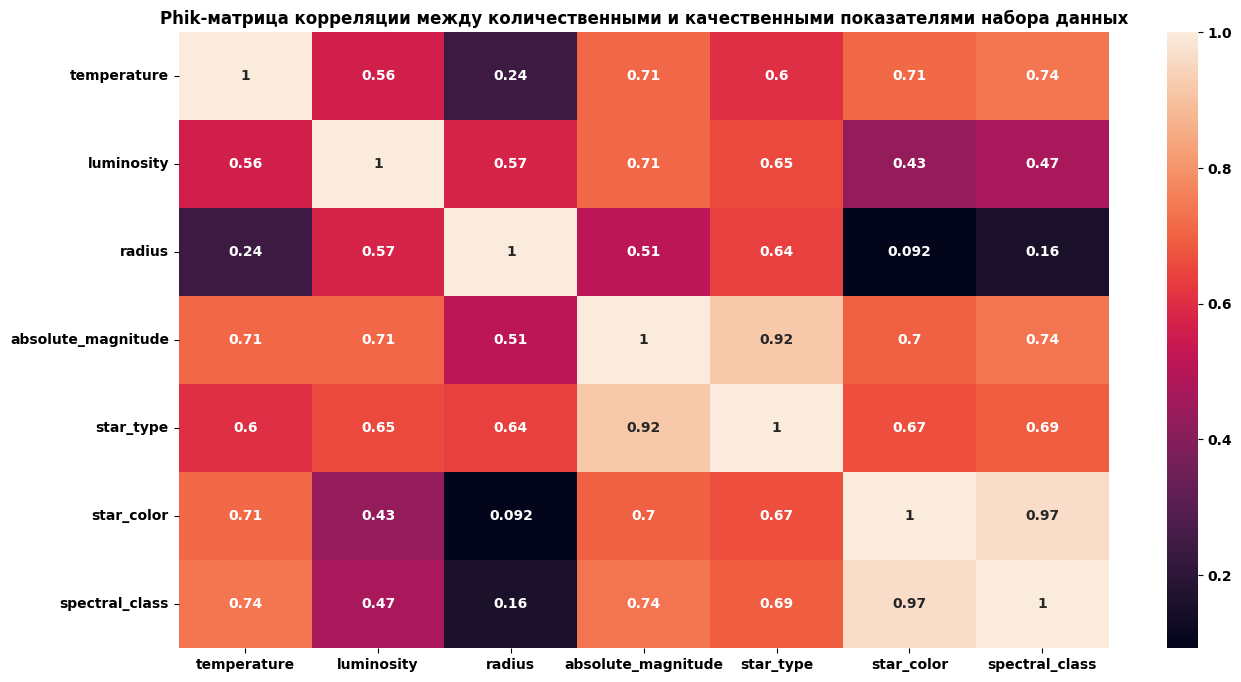

In [25]:
# построение матрицы корреляции по всем признакам
plt.figure(figsize=(15, 8))
(sns.heatmap(stars
             .phik_matrix(interval_cols = ['temperature', 'luminosity', 'radius', 'absolute_magnitude']), annot = True))
plt.title('Phik-матрица корреляции между количественными и качественными показателями набора данных', fontsize = 12)
plt.show()

**Вывод по промежуточному этапу:**

При анализе матрицы корреляции по **количественным и качественным признакам** заметна линейная взаимосвязь:
* между признаками и целевой переменной **temperature** наблюдается умеренная связь;
* между признаками **star_type** и **absolute_magnitude**; **star_color** и **star_type** наблюдается сильная связь;

В целом, все признаки неплохо хорошо коррелируют между собой, что в потенциале повышает шансы на верные прогнозы целевой переменной.

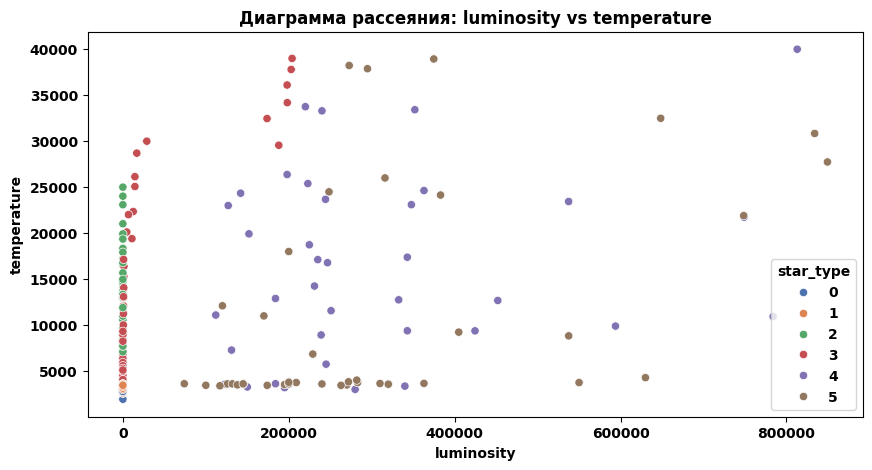

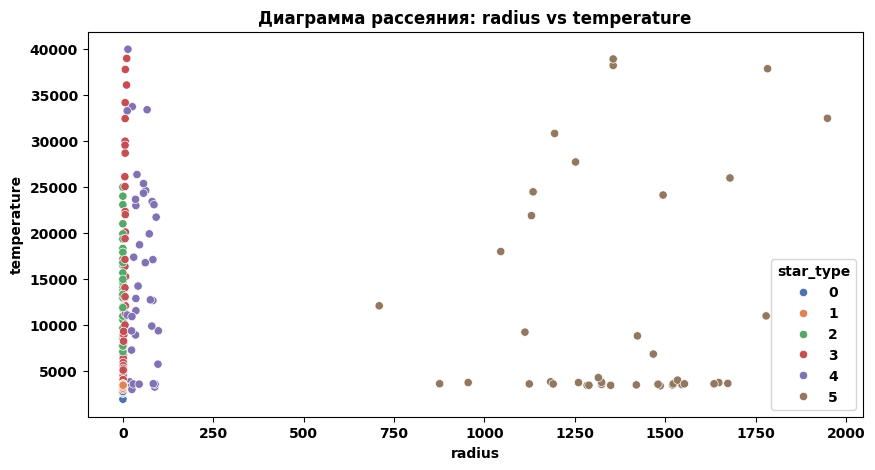

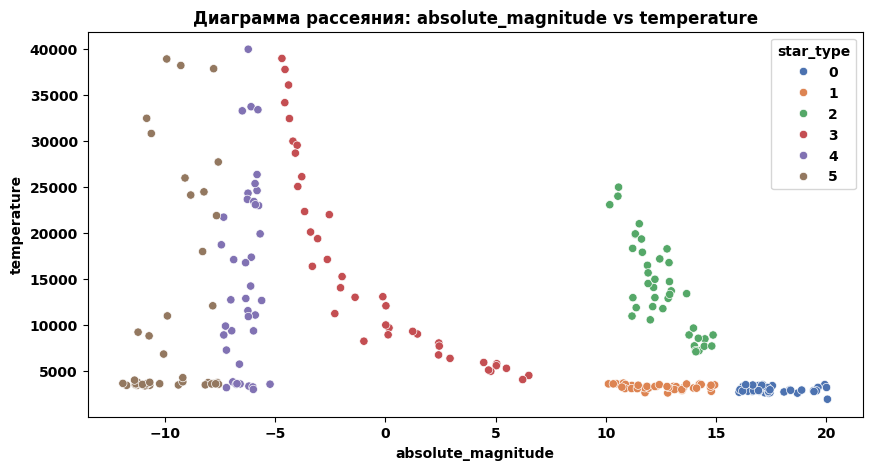

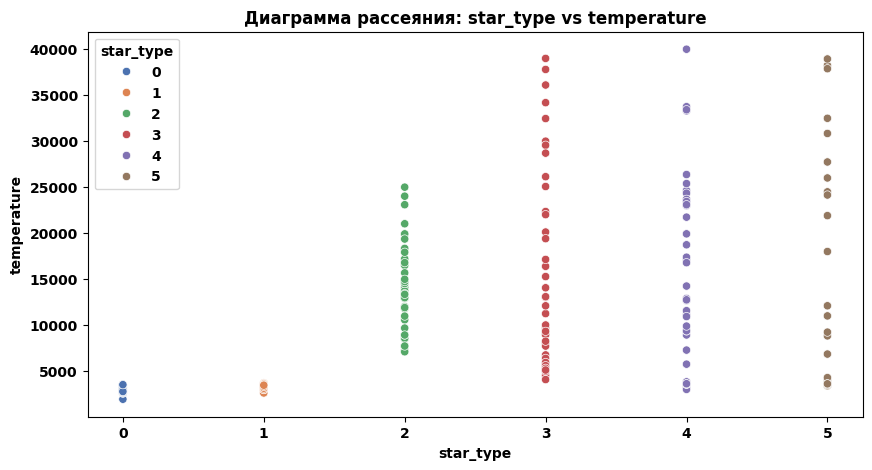

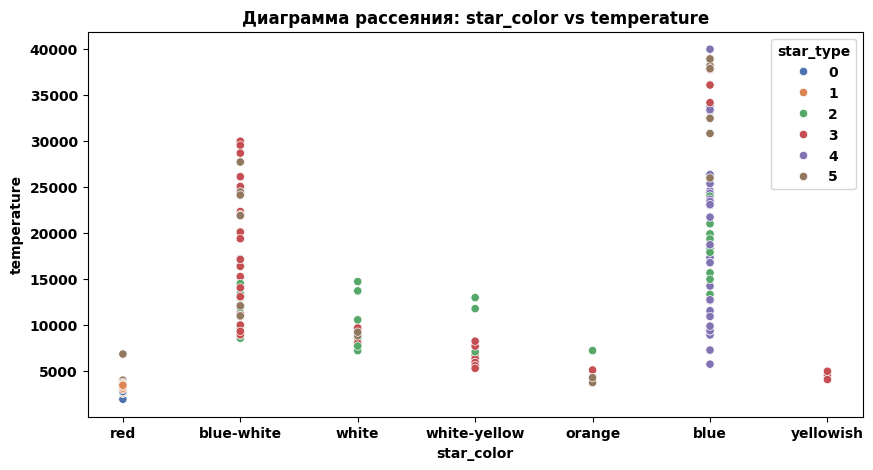

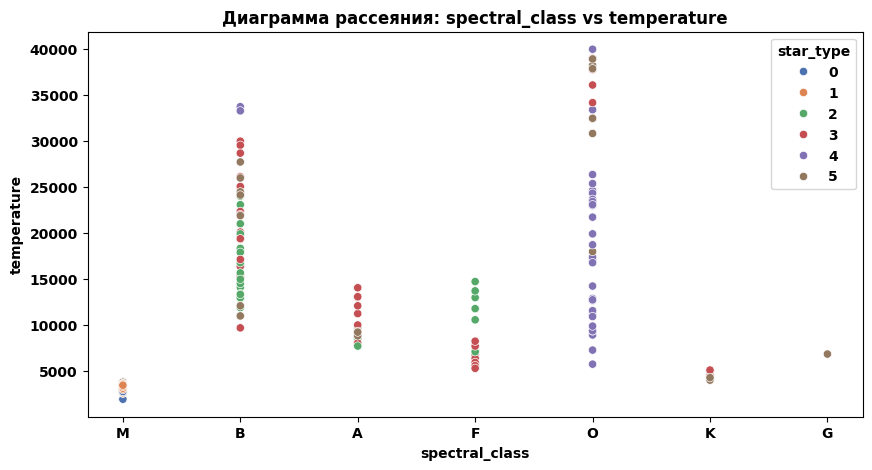

In [26]:
# построение диграмм рассеяния с визуализацией взаимосвязей между признаками и целевой переменной 
for features in stars.columns:
    if features != 'temperature':
        plt.figure(figsize=(10, 5))
        sns.scatterplot(data = stars, x = features, y = 'temperature', hue = 'star_type', palette = 'deep')
        plt.title(f'Диаграмма рассеяния: {features} vs temperature')
        plt.show()

**Вывод по промежуточному этапу**

По итогам анализа диаграмм рассеяния сформированы следующие выводы:
* **luminosity и temperature**. Наблюдаются два кластера:
    * Звезды типов 0 - 3 группируются около отметки 0 по признаку "светимость" и имеют более предсказуемую динамику температур;
    * Звезды типов 4 - 5 имеют более хаотичное распределение температур по мере роста значений по признаку "светимость";
* **radius и temperature**. Наблюдаются два кластера:
    * Звезды типов 0 - 4 группируются около отметки 0 по признаку "радиус" и имеют более предсказуемую динамику температур;
    * Звезды типа 5 имеют более хаотичное распределение температур по мере роста значений по признаку "радиус";
* **absolute_magnitude и temperature**. Все звезды образуют группы соответственно их типам:
    * Заметен параболический характер изменения температуры у звезд типа 3 по мере роста значений по признаку.
    * У остальных типов значения сгруппированы в определенных областях с предсказуемой динамикой температуры в зависимости от значений признака. Можно говорить о наличии линейной связи;
* **star_type и temperature**. Наблюдаются два кластера:
    * Звезды типов 0 - 1 имеют температуру, не превыщающую показателя в 5 000 К;
    * Звезды остальных типов как правило не имеют объектов с температурой ниже показателя в 5 000 К;

**Вывод**

1. Построена матрица корреляции Спирмана - произведен анализ взаимосвязей:
    * между признаками и целевой переменной **temperature**:
        * **luminosity** - в большинстве случаев чем выше светимость звезды, тем выше температура;
        * **radius** - в большинстве случаев чем больше радиус, тем выше температура;
    * между признаками:
        * **luminosity** и **radius** - чем больше радиус, тем больше светимость;
        * Взаимосвязь с признаком **absolute_magnitude** необходимо рассмотреть на корреляционной диграмме с учетом непрерывности значений по признаку, а также в связи с категориальными данными.
2. Построена Phik-матрица корреляции - произведен анализ взаимосвязей **количественных и качественных** признаков с целевой переменной:
    * между признаками и целевой переменной **temperature** наблюдается умеренная связь;
    * между признаками **star_type** и **absolute_magnitude**; **star_color** и **star_type** наблюдается сильная связь;
3. По итогам анализа диаграмм рассеяния сформированы следующие выводы:
    * **luminosity и temperature**. Наблюдаются два кластера:
        * Звезды типов 0 - 3 группируются около отметки 0 по признаку "светимость" и имеют более предсказуемую динамику температур;
        * Звезды типов 4 - 5 имеют более хаотичное распределение температур по мере роста значений по признаку "светимость";
    * **radius и temperature**. Наблюдаются два кластера:
        * Звезды типов 0 - 4 группируются около отметки 0 по признаку "радиус" и имеют более предсказуемую динамику температур;
        * Звезды типа 5 имеют более хаотичное распределение температур по мере роста значений по признаку "радиус";
    * **absolute_magnitude и temperature**. Все звезды образуют группы соответственно их типам:
        * Заметен параболический характер изменения температуры у звезд типа 3 по мере роста значений по признаку.
        * У остальных типов значения сгруппированы в определенных областях с предсказуемой динамикой температуры в зависимости от значений признака. Можно говорить о наличии линейной связи;
    * **star_type и temperature**. Наблюдаются два кластера:
        * Звезды типов 0 - 1 имеют температуру, не превыщающую показателя в 5 000 К;
        * Звезды остальных типов как правило не имеют объектов с температурой ниже показателя в 5 000 К;

В целом, **все признаки неплохо хорошо коррелируют между собой и целевой переменной**, что в потенциале повышает шансы на верные прогнозы целевой переменной.

## Построение моделей машинного обучения <a class = 'anchor' id = 'Моделирование'></a>

### Подготовка данных <a class = 'anchor' id = 'Моделирование_подготовка'></a>

Данный блок характеризуется следующими последовательными действиями:

1. Инициализация пользовательской функции подготовки данных:
    * Разделение исходного набора `stars` на область признаков и вектор целевой переменной - инициализация переменных `X` и **y** соответственно;
    * Инициализация переменных `X_train`, `X_test`, **y_train** и **y_test** для хранения обучающих и тестовых наборов данных;
    * Масштабирование количественных значений стратегией стандартизации;
    * Кодирование категориальных значений стратегиями OneHotEncoding и OrdinalEncoding;
    * Объединение обработанных значений в общие наборы данных - перезапись переменных `X_train` и `X_test`;
2. Отбор категориальных и количественных значений в отдельные переменные - инициализация переменных **ohe_cols**, **ord_cols** и **num_cols**;
3. Преобразование исходного набора данных;
4. Формирование вывода по итогам данного этапа.

In [27]:
# инициализация пользовательской функции расчета модели линейной регрессии
def data_preparing (df : pd.DataFrame, num_col_names : list, ohe_col_names : list, ord_col_names : list):
    
    # формирование области признаков и вектора целевой переменной
    X = df.drop('temperature', axis = 1)
    y = df['temperature']

    # разделение набора данных на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = TEST_SIZE, random_state = RANDOM_STATE
    )

    # инициализация переменной 'scaler'
    scaler = StandardScaler()

    # инициализация переменной 'ohe_encoder'
    ohe_encoder = OneHotEncoder(sparse_output = False,
                            drop = 'first',
                            handle_unknown = 'ignore')
    
    # инициализация переменной 'ord_encoder'
    ord_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)

    # масштабирование количественных признаков в выборках
    X_train_sc = scaler.fit_transform(X_train[num_col_names])
    X_test_sc = scaler.transform(X_test[num_col_names])

    # кодирование категориальных признаков
    X_train_ohe = ohe_encoder.fit_transform(X_train[ohe_col_names])
    X_test_ohe = ohe_encoder.transform(X_test[ohe_col_names])

    X_train_ord = ord_encoder.fit_transform(X_train[ord_col_names])
    X_test_ord = ord_encoder.transform(X_test[ord_col_names])

    # список новых столбцов после кодирования признаков
    encoder_col_names = ohe_encoder.get_feature_names_out()

    # создание новых датафреймов после кодирования
    X_train_ohe = pd.DataFrame(X_train_ohe, columns = encoder_col_names)
    X_test_ohe = pd.DataFrame(X_test_ohe, columns = encoder_col_names)

    X_train_ord = pd.DataFrame(X_train_ord, columns = ord_col_names)
    X_test_ord = pd.DataFrame(X_test_ord, columns = ord_col_names)

    # создание новых датафреймов после масштабирования
    X_train_sc = pd.DataFrame(X_train_sc, columns = num_col_names)
    X_test_sc = pd.DataFrame(X_test_sc, columns = num_col_names)

    # объединение наборов данных
    X_train = pd.concat([X_train_ohe, X_train_ord, X_train_sc], axis = 1)
    X_test = pd.concat([X_test_ohe, X_test_ord, X_test_sc], axis = 1)

    return X_train, X_test, y_train, y_test

In [28]:
# инициализация переменных для хранения названий признаков в соответствующих категориях
ohe_cols = ['star_color']
ord_cols = ['star_type']
num_cols = ['absolute_magnitude', 'radius', 'luminosity']

# преобразование наборов
X_train, X_test, y_train, y_test = data_preparing(stars, num_cols, ohe_cols, ord_cols)

**Вывод**

1. Инициализирована пользовательской функция - **data_preparing** - подготовки данных, в которой выполняется:
    * Разделение исходного набора `stars` на область признаков и вектор целевой переменной - инициализация переменных `X` и **y** соответственно;
    * Инициализация переменных `X_train`, `X_test`, **y_train** и **y_test** для хранения обучающих и тестовых наборов данных;
    * Масштабирование количественных значений стратегией стандартизации;
    * Кодирование категориальных значений стратегиями OneHotEncoding и OrdinalEncoding;
    * Объединение обработанных значений в общие наборы данных - перезапись переменных `X_train` и `X_test`;
2. Произведен отбор категориальных и количественных значений в отдельные переменные - инициализированы переменные **ohe_cols**, **ord_cols** и **num_cols**;
3. Выполнено преобразование исходного набора данных.

### Построение baseline-модели прогнозирования на базе нейронной сети <a class = 'anchor' id = 'Моделирование_baseline'></a>

Данный блок характеризуется следующими последовательными действиями:

1. Ввод переменных для задания констант, формирующих нейронную сеть:
    * Количество скрытых слоев;
    * Количество нейронов;
    * Функции активации на скрытых и выходном слоях
2. Создание класса для задания архитектуры нейронной сети;
3. Инициализация пользовательских функций обучения / тестирования модели;
4. Инициализация пользовательской функции построения графика прогноз / факт;
5. Инициализация пользовательской функции генерации весов;
6. Преобразование входных данных в тензоры PyTorch
7. Обучение нейронной сети и проверка качества прогнозов на тестовой выборке
8. Формирование вывода по итогам данного этапа.

In [29]:
# задание константных значений для формирования нейронной сети
n_in_neurons = len(X_train.columns)
n_hidden_neurons_1 = 8
n_hidden_neurons_2 = 5
n_out_neurons = 1

In [30]:
# Создание класса нейронной сети с 3 скрытыми слоями
class NeuralNet(nn.Module):
    def __init__(self, in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(in_neurons, hidden_neurons_1)
        self.ac1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)
        self.ac2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(hidden_neurons_2, out_neurons)
        self.ac3 = nn.LeakyReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        x = self.ac3(x)
        return x


# Инициализация нейросети
net = NeuralNet(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)

In [31]:
# инициализация оптимизатора
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3)
# функция потерь
loss = nn.MSELoss()
# количество эпох обучения
num_epochs = 9_001

In [32]:
# Функция обучения модели
def model_training(train_x, train_y):
    optimizer.zero_grad()
    preds = net.forward(train_x).flatten()
    
    # L2-Регуляризация весов
    l2_lambda = 0.001
    l2_norm = sum(p.pow(2.0).sum() for p in net.parameters())
    loss_value = torch.sqrt(loss(preds, train_y)) + l2_lambda * l2_norm
    loss_value.backward()

    optimizer.step()

# Функция тестирования модели
def model_testing(epoch):
    net.eval()
    test_preds = net.forward(X_test).flatten()
    print('Epoch #:', epoch)
    print('RMSE =', torch.sqrt(loss(test_preds, y_test)).item(), '\n')
    return test_preds

In [33]:
# Функция для обучения с использованием батчей
def batch_training(epochs_num, epoch_test):
    batch_size = 100
    num_batches = math.ceil(len(X_train) / batch_size)

    for epoch in range(epochs_num):
        order = np.random.permutation(len(X_train))
        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            
            optimizer.zero_grad()

            batch_indexes = order[start_idx:start_idx + batch_size]
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]

            model_training(X_batch, y_batch)
        if epoch % epoch_test == 0:
            y_pred = model_testing(epoch)
    return y_pred

In [34]:
# Функция для отображения графика "Факт-Прогноз"
def show_graph(y_pred):
    start = 0
    end = len(y_test)
    
    basic_df = y_test[start:end]
    nn_df = y_pred[start:end]

    plt.figure(figsize=(7, 7))
    plt.bar(range(start, end), nn_df.detach().numpy(), color='orange', label='Прогноз')
    plt.bar(range(start, end), basic_df, color='blue', width=0.5, label='Факт')

    plt.legend()
    plt.title('Факт-Прогноз', fontsize=16)
    plt.xlabel('Номер звезды в таблице данных', fontsize=14)
    plt.ylabel('Температура звезды', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

In [35]:
# Функция для инициализации весов
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.kaiming_uniform_(
            layer.weight,
            mode='fan_in',
            nonlinearity='relu'
        )

# Инициализация весов нейросети
net.apply(init_weights)

NeuralNet(
  (fc1): Linear(in_features=10, out_features=8, bias=True)
  (ac1): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=8, out_features=5, bias=True)
  (ac2): LeakyReLU(negative_slope=0.01)
  (fc3): Linear(in_features=5, out_features=1, bias=True)
  (ac3): LeakyReLU(negative_slope=0.01)
)

In [36]:
# преобрзование входных данных в тензоры PyTorch
X_train = torch.FloatTensor(X_train.values)
X_test = torch.FloatTensor(X_test.values)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

In [37]:
# обучение модели нейронной сети
for epoch in range(num_epochs):
    model_training(X_train, y_train)
    if epoch % 1_000 == 0 or epoch == num_epochs - 1:
        preds = model_testing(epoch)

Epoch #: 0
RMSE = 14626.37890625 

Epoch #: 1000
RMSE = 14244.087890625 

Epoch #: 2000
RMSE = 12397.94921875 

Epoch #: 3000
RMSE = 10071.5859375 

Epoch #: 4000
RMSE = 8921.953125 

Epoch #: 5000
RMSE = 8335.5634765625 

Epoch #: 6000
RMSE = 7927.26025390625 

Epoch #: 7000
RMSE = 7623.94970703125 

Epoch #: 8000
RMSE = 7408.17529296875 

Epoch #: 9000
RMSE = 7175.9443359375 



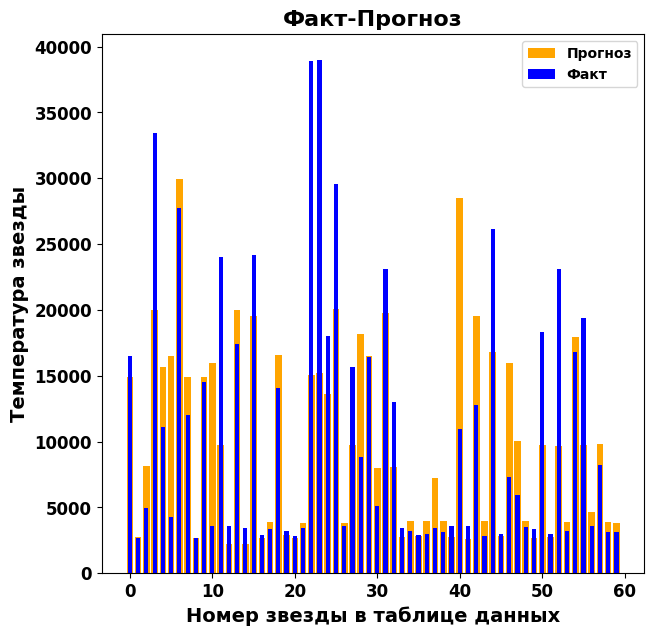

In [38]:
# Создание графика "Факт-Прогноз" по полученным результатам нейросети
show_graph(preds)

**Вывод**

1. Введены переменные для задания констант, формирующих нейронную сеть:
    * Количество скрытых слоев - **2**;
    * Количество нейронов:
        * На входном слое - **равно количеству признаков модели**;
        * На 1 скрытом слое - **8**;
        * На 2 скрыто слое - **5**;
        * На выходном слое - **1**.
    * Функции активации на скрытых и выходном слоях - **LeakyReLU**;
2. Создан класс для задания архитектуры нейронной сети;
3. Инициализированы пользовательские функции обучения / тестирования модели;
4. Инициализированы пользовательские функции построения графика прогноз / факт;
5. Инициализированы пользовательские функции генерации весов;
6. Преобразованы входные данные в тензоры PyTorch;
7. Проведены обучение нейронной сети и проверка качества прогнозов на тестовой выборке:
    * **На эпохе под номером 9 000 метрика RMSE составляет - 7 064**.

### Построение улучшенной модели нейронной сети <a class = 'anchor' id = 'Моделирование_улучшение'></a>

#### Перебор гиперпараметров модели нейронной сети с помощью библиотеки Optuna <a class = 'anchor' id = 'Моделирование_улучшение_перебор'></a>

Данный блок характеризуется следующими последовательными действиями:

1. Инициализация пользовательской функции изменяемой модели с перебором параметров (включая количество скрытых слоев - до 5);
2. Инициализация пользовательской функции подбора параметров библиотекой Optuna;
3. Инициализация пользовательской функции по выводу метрик на каждом этапе обучения;
4. Вывод на экран лучших параметров модели нейронной сети;
5. Инициализация и обучение модели нейронной сети с лучшими гиперпараметрами;
6. Получение прогноза на тестовых данных и расчет метрики RMSE;
7. Построение визуализации сравнения прогнозных и тестовых значений;
8. Формирование вывода по итогам данного этапа.

In [ ]:
# инициализация количества эпох обучения
EPOCHS = 401

In [40]:
# пользовательская функция изменяемой модели нейронной сети
def changeable_model(trial):
    # Зададим количество слоев
    n_layers = trial.suggest_int("n_layers", 1, 5)
    layers = []
    # Количество нейронов на входе
    in_features = X_train.shape[1]
    
    # Цикл создания скрытых слоев для модели
    for i in range(n_layers):
        # Количество нейронов на выходе
        out_features = trial.suggest_int("n_units_{}".format(i), 2, 30)
        # Добавление функции активации и регуляризации
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        momentum = trial.suggest_float("momentum_{}".format(i), 0.1, 0.4, step=0.01)
        eps = trial.suggest_float("eps_{}".format(i), 1e-6, 1e-4, log=True)
        layers.append(nn.BatchNorm1d(out_features, momentum=momentum, eps=eps))
        p = trial.suggest_float("dropout_{}".format(i), 0.1, 0.5, step=0.05)
        layers.append(nn.Dropout(p))
        in_features=out_features
    # Выходной слой
    layers.append(nn.Linear(out_features, 1))
    layers.append(nn.ReLU())
    return nn.Sequential(*layers)

In [41]:
# инициализация пользовательской функции подбора параметров библиотекой optuna
def objective(trial: optuna.Trial):
    
    # Исходные данные для случайных значений модели
    torch.manual_seed(2023)
    torch.use_deterministic_algorithms(True)
    
        
    # Улучшаемая модель с дополнительными слоями Dropout и BatchNorm
    net = changeable_model(trial)
    
    # Остальные перебираемые параметры
    lr = trial.suggest_float("lr", 1e-3, 1e-2, log=True)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    batch_size = trial.suggest_int("batch_size", 10, 30, 5)
    num_batches = math.ceil(len(X_train)/batch_size)
    
    # Функция потерь
    loss = nn.MSELoss(reduction='sum') 
    
    # Список для записи метрики на тестовой выборке
    result_list = []
    
    
    # Создаем цикл обучения и предсказания нейросети
    for epoch in range(EPOCHS):
        order = np.random.permutation(len(X_train))
        net.train()
        
        # Подбор весов на тренировочной выборке
        for batch_idx in range(num_batches):
            # Деление на батчи
            start_index = batch_idx * batch_size
            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]
            # Обнуление градиента
            optimizer.zero_grad()
            
            # Прямой проход
            preds = net(X_batch).flatten()
            
            loss_value = loss(preds, y_batch)
            
            # Обратный проход
            loss_value.backward()
            optimizer.step()
            
        # Предсказания на тестовой выборке
        if epoch % 100 == 0 or epoch == num_epochs - 1:
            net.eval()
            test_preds = net.forward(X_test)
            rmse_opt = root_mean_squared_error(y_test, test_preds.detach().numpy())
            result_list.append(rmse_opt)
            
    # Сохраняем список с метриками для вывода на экран        
    trial.set_user_attr("result_list", result_list)
    return rmse_opt

In [42]:
# инициалитзация функции callback для вывода метрик
def custom_callback(study: optuna.Study, trial: optuna.Trial):
    trial.user_attrs["result_list"]
    result_list = trial.user_attrs["result_list"]
    print(f"Trial {trial.number}: result={result_list}")

In [ ]:
# отключение логгирования optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# обучение объекта optuna
study = optuna.create_study(direction="minimize", 
                            sampler = TPESampler(seed=42),
                            pruner = optuna.pruners.HyperbandPruner(),
                            study_name = f"Training_example_{dt.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}")
study.optimize(objective, n_trials = 50, callbacks = [custom_callback])

C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 0: result=[14625.689, 13201.538, 10221.6875, 7306.855]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 1: result=[14626.781, 14582.083, 14487.964, 14351.072]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 2: result=[14626.128, 6227.6074, 5251.5806, 4826.5273]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 3: result=[14626.82, 14047.173, 12536.576, 10806.888]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 4: result=[14626.291, 12481.126, 7639.098, 4876.91]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 5: result=[14626.545, 12490.007, 8411.788, 5206.241]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 6: result=[14626.601, 14549.229, 14364.446, 14087.051]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 7: result=[14626.262, 10393.495, 5634.815, 4575.67]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 8: result=[14626.85, 14608.906, 14571.083, 14505.868]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 9: result=[14626.794, 14428.87, 13895.723, 13197.283]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 10: result=[14626.4, 14327.221, 13556.9795, 12637.288]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 11: result=[14626.422, 6478.846, 5702.565, 5792.142]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 12: result=[14625.373, 6997.8438, 5330.003, 4815.272]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 13: result=[14626.495, 14383.79, 13733.897, 12827.232]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 14: result=[14626.282, 8912.05, 4973.618, 4943.0703]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 15: result=[14626.294, 13695.636, 11742.562, 9639.022]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 16: result=[14626.85, 14408.683, 13902.195, 13299.337]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 17: result=[14626.185, 9672.002, 5204.5825, 5194.0376]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 18: result=[14626.667, 12576.856, 8977.547, 6065.9077]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 19: result=[14626.114, 12585.403, 8881.413, 5698.1333]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 20: result=[14626.227, 13063.89, 9770.095, 7409.5776]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 21: result=[14625.752, 6225.076, 4961.075, 5310.098]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 22: result=[14625.832, 7176.9883, 5211.978, 5132.5327]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 23: result=[14625.82, 6563.532, 4759.2764, 5079.687]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 24: result=[14626.69, 10821.873, 5721.6533, 4869.593]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 25: result=[14626.019, 11888.932, 7655.794, 4998.21]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 26: result=[14626.2295, 11441.71, 6821.1143, 5675.2944]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 27: result=[14625.539, 10421.277, 5043.6396, 4909.442]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 28: result=[14625.884, 9710.313, 5070.5254, 5016.3857]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 29: result=[14626.34, 14238.103, 13136.189, 11732.739]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 30: result=[14626.279, 7811.376, 5174.136, 5936.7373]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 31: result=[14626.667, 10686.831, 5082.616, 4551.015]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 32: result=[14626.807, 12166.149, 7351.6772, 5997.963]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 33: result=[14626.694, 14489.009, 14176.313, 13722.505]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 34: result=[14626.51, 11412.21, 5886.1704, 4803.989]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 35: result=[14626.597, 13753.831, 11805.706, 9184.26]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 36: result=[14626.106, 11982.828, 6927.6196, 4700.0493]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 37: result=[14626.85, 13747.374, 11388.2, 9246.514]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 38: result=[14626.623, 11961.646, 8195.499, 5783.537]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 39: result=[14626.348, 14122.977, 12944.07, 11147.586]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 40: result=[14626.575, 12704.033, 8422.635, 5594.527]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 41: result=[14626.361, 9270.443, 4878.0527, 4338.7505]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 42: result=[14626.279, 12313.257, 6903.3335, 4465.7305]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 43: result=[14626.253, 12358.74, 7820.937, 5262.9155]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 44: result=[14626.215, 8605.173, 5381.9424, 5122.9907]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 45: result=[14626.175, 13997.075, 12357.886, 10316.582]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 46: result=[14626.618, 14566.328, 14428.931, 14243.153]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 47: result=[14626.394, 12207.624, 7198.3833, 4720.596]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 48: result=[14626.689, 13840.023, 12207.045, 9944.276]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 49: result=[14626.695, 11477.5205, 6609.17, 4852.5615]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 50: result=[14626.673, 13663.195, 12063.686, 9316.812]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 51: result=[14626.041, 12502.96, 7859.725, 5313.2837]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 52: result=[14626.232, 12220.041, 7456.2646, 4590.718]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 53: result=[14626.604, 13258.353, 10509.938, 7394.172]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 54: result=[14626.791, 13242.511, 10082.913, 6714.6934]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 55: result=[14626.595, 11907.355, 7598.227, 4724.7944]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 56: result=[14625.939, 8778.114, 4888.349, 4732.712]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 57: result=[14626.514, 12829.578, 8188.9927, 5455.8413]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 58: result=[14626.076, 11409.937, 6607.3115, 4919.9146]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 59: result=[14626.601, 13292.412, 10429.603, 7195.1807]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 60: result=[14625.961, 9462.428, 5404.2183, 5416.927]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 61: result=[14626.081, 12284.175, 8043.7954, 4993.1196]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 62: result=[14626.322, 11521.265, 6579.064, 5168.8276]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 63: result=[14626.284, 11748.322, 6441.393, 5241.5283]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 64: result=[14626.077, 13182.905, 10288.917, 7184.577]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 65: result=[14626.516, 13239.83, 10060.1, 6848.475]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 66: result=[14626.796, 10828.142, 6471.7866, 5419.231]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 67: result=[14626.266, 10166.611, 5302.079, 4647.7646]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 68: result=[14624.354, 5469.1367, 5250.025, 5535.1963]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 69: result=[14626.234, 10223.423, 5010.4727, 4900.4043]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 70: result=[14625.102, 6458.198, 4965.461, 5013.0186]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 71: result=[14626.591, 11280.254, 6688.668, 4884.6025]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 72: result=[14626.804, 12633.8125, 8843.495, 5675.113]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 73: result=[14626.169, 10331.864, 5270.897, 4892.9023]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 74: result=[14626.85, 14626.85, 14626.85, 14626.85]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 75: result=[14626.089, 11097.952, 6391.452, 4690.772]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 76: result=[14626.125, 11502.958, 7160.918, 5239.403]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 77: result=[14626.627, 12488.082, 8413.786, 5996.9805]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 78: result=[14626.289, 10779.226, 6410.7793, 4633.7295]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 79: result=[14626.61, 11547.835, 6351.0537, 5014.3433]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 80: result=[14626.244, 12739.002, 8400.327, 6518.058]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 81: result=[14626.139, 11491.007, 6462.326, 4809.0596]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 82: result=[14625.981, 9430.896, 5059.493, 4885.427]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 83: result=[14626.8125, 11179.022, 5640.566, 4881.341]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 84: result=[14625.981, 12433.904, 8757.962, 5921.908]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 85: result=[14626.46, 13712.327, 11504.817, 9423.425]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 86: result=[14626.6045, 10269.43, 5741.2153, 4595.47]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 87: result=[14626.512, 11757.006, 6434.7256, 4640.2773]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 88: result=[14626.487, 13553.801, 10107.796, 7957.0415]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 89: result=[14626.238, 11068.948, 5766.9424, 5305.8643]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 90: result=[14626.439, 11592.147, 6540.7573, 4758.876]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 91: result=[14626.633, 10581.237, 6007.1, 4552.913]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 92: result=[14626.358, 9955.58, 5137.2534, 4587.2007]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 93: result=[14626.474, 10191.633, 5148.901, 5875.9375]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 94: result=[14626.507, 9739.158, 5441.1206, 4614.148]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 95: result=[14626.638, 9561.591, 5574.588, 4486.282]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 96: result=[14626.071, 9485.771, 5297.2026, 4941.8145]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 97: result=[14626.329, 9326.471, 5074.7183, 4479.182]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 98: result=[14626.85, 10434.441, 5162.8203, 4805.366]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 99: result=[14626.41, 8823.1455, 5284.8105, 4817.701]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 100: result=[14625.835, 10983.649, 5622.2437, 4693.6226]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 101: result=[14626.468, 9695.2705, 5375.8774, 4656.2964]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 102: result=[14626.478, 10152.449, 5658.423, 4517.368]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 103: result=[14626.666, 10850.642, 5626.0215, 4980.4614]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 104: result=[14626.537, 10312.743, 5181.7285, 4902.241]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 105: result=[14626.433, 11032.198, 6187.5405, 4931.715]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 106: result=[14626.404, 12314.598, 7285.623, 5322.0386]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 107: result=[14626.509, 10767.427, 5891.3145, 5027.451]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 108: result=[14626.527, 9511.984, 4922.4194, 4695.18]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 109: result=[14626.407, 11490.507, 6781.8164, 4995.247]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 110: result=[14626.698, 10480.794, 5415.293, 5758.1597]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 111: result=[14626.502, 8973.459, 4652.0796, 4813.562]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 112: result=[14626.776, 9880.663, 9016.105, 4532.8203]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 113: result=[14626.629, 10410.655, 5329.045, 4944.483]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 114: result=[14626.85, 14288.949, 13504.163, 12342.339]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 115: result=[14626.301, 10927.655, 5470.6387, 4432.534]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 116: result=[14626.837, 14073.954, 12785.685, 11178.934]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 117: result=[14626.027, 9546.013, 5085.7314, 5016.062]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 118: result=[14626.136, 12125.592, 7242.143, 5658.365]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 119: result=[14626.423, 11820.206, 6909.5425, 4767.889]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 120: result=[14626.343, 10568.8, 5774.769, 4754.6445]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 121: result=[14626.548, 11629.114, 6797.2764, 4751.6553]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 122: result=[14626.603, 11572.004, 7325.435, 4781.159]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 123: result=[14626.65, 14426.757, 13958.606, 13277.681]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 124: result=[14626.369, 11379.711, 6294.919, 4367.671]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 125: result=[14626.628, 11730.396, 7531.3906, 5550.2017]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 126: result=[14626.767, 9638.754, 5229.1406, 4415.401]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 127: result=[14625.914, 9609.196, 4887.447, 4693.908]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 128: result=[14626.463, 9666.083, 5048.9385, 5101.0386]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 129: result=[14626.443, 10160.303, 4845.42, 4696.5806]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 130: result=[14626.069, 10443.749, 5313.3013, 4775.3745]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 131: result=[14626.471, 9741.283, 4924.902, 4653.8203]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 132: result=[14626.316, 11987.741, 7209.3213, 4998.871]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 133: result=[14626.722, 13555.434, 11194.366, 8677.401]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 134: result=[14626.569, 11481.518, 6770.0234, 5581.9326]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 135: result=[14626.657, 10761.5, 5752.7207, 4764.983]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 136: result=[14626.355, 10875.8125, 6017.205, 4845.845]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 137: result=[14626.106, 12634.348, 8437.359, 5429.19]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 138: result=[14625.862, 9369.324, 4747.867, 4862.8237]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 139: result=[14626.658, 13119.671, 10071.484, 6022.668]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 140: result=[14626.85, 11586.587, 7202.4585, 4793.326]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 141: result=[14625.407, 9414.352, 4880.6396, 4926.3604]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 142: result=[14626.362, 9956.173, 5170.3657, 4591.519]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 143: result=[14626.843, 10342.556, 5485.1636, 4800.3975]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 144: result=[14625.369, 7713.93, 4732.096, 4583.442]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 145: result=[14625.045, 7911.746, 4958.0977, 5130.0303]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 146: result=[14626.349, 8105.7344, 4796.762, 4626.871]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 147: result=[14626.1455, 10458.285, 5764.988, 4530.96]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 148: result=[14626.389, 12202.117, 7882.8545, 4901.7876]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 149: result=[14625.401, 8562.758, 4748.8296, 4634.4507]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 150: result=[14626.457, 13208.085, 9788.391, 7253.238]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 151: result=[14626.158, 10590.846, 5063.813, 4670.1187]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 152: result=[14625.872, 7753.1235, 5117.9336, 5292.125]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 153: result=[14625.832, 7864.4043, 4809.6655, 4922.424]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 154: result=[14625.936, 8927.805, 5231.535, 5194.884]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 155: result=[14626.093, 10368.99, 4947.709, 4901.467]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 156: result=[14626.539, 10775.624, 5454.613, 4739.278]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 157: result=[14626.063, 9934.809, 5406.227, 5270.9185]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 158: result=[14626.23, 11109.632, 6429.122, 4830.357]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 159: result=[14626.661, 11850.559, 7364.0645, 5221.8823]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 160: result=[14625.888, 9456.796, 4620.991, 4712.2856]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 161: result=[14625.844, 10066.97, 5096.8496, 4596.867]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 162: result=[14626.453, 10525.442, 6445.046, 4621.621]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 163: result=[14626.094, 9113.478, 4921.381, 4969.9536]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 164: result=[14626.285, 11543.393, 6403.2607, 5070.817]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 165: result=[14626.05, 6994.5386, 5056.183, 5102.815]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 166: result=[14626.519, 13177.964, 9837.306, 7096.4644]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 167: result=[14626.272, 10717.753, 5543.059, 4603.648]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 168: result=[14626.104, 11232.503, 6392.936, 4775.4204]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 169: result=[14625.712, 8920.545, 4915.66, 4782.8335]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 170: result=[14626.396, 14200.389, 13115.563, 11921.501]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 171: result=[14625.626, 8971.446, 4866.0747, 5050.439]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 172: result=[14626.511, 10315.526, 5298.6265, 4669.7607]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 173: result=[14626.706, 11317.491, 5903.341, 4697.111]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 174: result=[14625.98, 7290.1743, 5302.961, 5229.497]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 175: result=[14625.473, 9446.795, 5607.31, 5035.0347]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 176: result=[14626.282, 11515.057, 6354.7153, 5264.5967]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 177: result=[14626.163, 10636.185, 5152.248, 4641.338]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 178: result=[14626.399, 9828.574, 5414.3354, 4925.566]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 179: result=[14626.848, 10712.7, 5749.76, 4520.456]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 180: result=[14626.382, 9812.108, 5378.769, 5327.615]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 181: result=[14626.444, 10511.946, 6085.295, 5334.52]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 182: result=[14626.685, 11883.892, 6667.2534, 5080.1143]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 183: result=[14626.643, 11011.661, 6547.1597, 5090.8364]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 184: result=[14626.285, 8834.427, 5567.4233, 5157.1567]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 185: result=[14626.522, 12548.108, 8417.662, 5288.0015]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 186: result=[14626.001, 8557.734, 4977.3804, 5002.4727]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 187: result=[14626.484, 13093.867, 9402.031, 6234.051]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 188: result=[14626.379, 7503.1826, 4855.3506, 4523.5273]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 189: result=[14626.442, 7422.825, 4947.254, 4997.146]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 190: result=[14626.528, 8917.791, 5166.315, 4926.074]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 191: result=[14626.651, 13097.863, 9907.776, 6970.904]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 192: result=[14625.767, 8159.3135, 4429.9077, 5062.5854]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 193: result=[14626.251, 9135.84, 4821.018, 4806.223]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 194: result=[14626.405, 7134.103, 4537.7847, 5195.3525]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 195: result=[14625.818, 9363.251, 4908.586, 5298.124]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 196: result=[14626.416, 10585.479, 5969.988, 4607.0913]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 197: result=[14626.593, 10782.877, 5303.25, 4626.39]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 198: result=[14626.24, 8324.813, 5073.298, 4612.9917]


C:\Users\k.storozhuk\AppData\Local\Temp\ipykernel_11820\2928928911.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int("batch_size", 10, 30, 5)


Trial 199: result=[14626.306, 12587.74, 8428.071, 5867.1675]


In [44]:
print("Параметры лучшей модели:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Параметры лучшей модели:
	n_layers: 5
	n_units_0: 27
	momentum_0: 0.27
	eps_0: 7.464542404483622e-05
	dropout_0: 0.1
	n_units_1: 14
	momentum_1: 0.13
	eps_1: 2.2300410350408885e-05
	dropout_1: 0.25
	n_units_2: 9
	momentum_2: 0.15000000000000002
	eps_2: 1.2430729759640708e-05
	dropout_2: 0.1
	n_units_3: 14
	momentum_3: 0.28
	eps_3: 1.1243130538719886e-05
	dropout_3: 0.25
	n_units_4: 20
	momentum_4: 0.2
	eps_4: 3.311014755213165e-06
	dropout_4: 0.30000000000000004
	lr: 0.008709571735787697
	batch_size: 15


In [ ]:
# Исходные данные для случайных значений модели
torch.manual_seed(42)
torch.use_deterministic_algorithms(True)

# Создаем базовую модель и задаем для нее количество нейронов на каждом слое
in_neirons = X_train.shape[1]
hidden_neirons_1 = 18
hidden_neirons_2 = 21
out_neirons = 1

# Параметры лучшей модели
p_0 = 0.1
p_1 = 0.25
momentum_0 = 0.27
momentum_1 = 0.13
eps_0 = 7.464542404483622e-05
eps_1 = 2.2300410350408885e-05
lr = 0.008709571735787697
batch_size = 15

net = nn.Sequential(
                    nn.Linear(in_neirons, hidden_neirons_1), 
                    nn.ReLU(),
                    nn.BatchNorm1d(hidden_neirons_1, momentum=momentum_0, eps=eps_0),
                    nn.Dropout(p_0),
                    nn.Linear(hidden_neirons_1, hidden_neirons_2), 
                    nn.ReLU(),
                    nn.BatchNorm1d(hidden_neirons_2, momentum=momentum_1, eps=eps_1),
                    nn.Dropout(p_1),
                    nn.Linear(hidden_neirons_2, out_neirons), 
                    nn.ReLU()
                )

# Укажем оптимизатор Adam со скоростью обучения посчитанной ранее
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
# Функция потерь будет MSELoss
loss = nn.MSELoss()
# Вычисляем количество батчей
num_batches = math.ceil(len(X_train)/batch_size)
# Количество эпох
num_epochs = 401

# Создаем цикл обучения и предсказания нейросети
for epoch in range(num_epochs):
    order = np.random.permutation(len(X_train))
    net.train()
    # Подбор весов на тренировочной выборке
    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size
        optimizer.zero_grad()

        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]

        preds = net.forward(X_batch).flatten()

        loss_value = loss(preds, y_batch)

        loss_value.backward()

        optimizer.step()
    # Предсказания на тестовой выборке
    if epoch % 200 == 0 or epoch == num_epochs - 1:
        net.eval()
        test_preds = net.forward(X_test)
        rmse = root_mean_squared_error(y_test, test_preds.detach().numpy())
        print(f'Epoch {epoch} complite with RMSE = {rmse}')

Epoch 0 complite with RMSE = 14626.392578125
Epoch 200 complite with RMSE = 6210.73828125
Epoch 399 complite with RMSE = 4457.2041015625


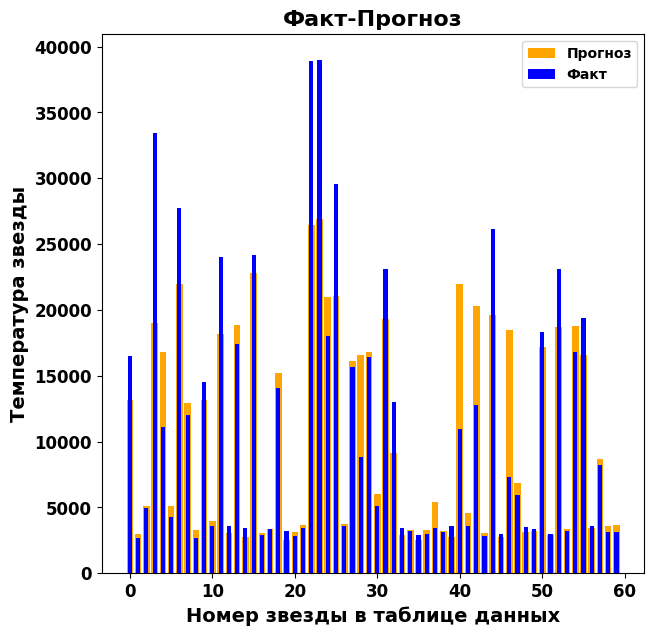

In [ ]:
# построение графика сравнения
show_graph(test_preds.data.flatten())

**Вывод**

1. Инициализирована переменная для хранения константного значения количества эпох обучения - **EPOCHS = 400**
2. Инициализирована пользовательская функция **changeable_model** изменяемой модели с перебором параметров (включая количество скрытых слоев - до 5);
3. Инициализирована пользовательская функция подбора параметров библиотекой Optuna;
4. Инициализирована пользовательская функция по выводу метрик на каждом этапе обучения;
5. Выведены на экран лучшие параметры модели для нейронной сети;
6. Инициализирована и обучена модель нейронной сети с лучшими гиперпараметрами - **net**:
    * in_neirons - количество признаков обучающего набора данных;
    * hidden_neirons_1 = 18;
    * hidden_neirons_2 = 21;
    * out_neirons = 1;
    * p_0 = 0.1
    * p_1 = 0.25
    * momentum_0 = 0.27
    * momentum_1 = 0.13
    * eps_0 = 7.464542404483622e-05
    * eps_1 = 2.2300410350408885e-05
    * lr = 0.008709571735787697
    * batch_size = 15
7. Получен прогноз на тестовых данных и рассчитана метрика RMSE - **4 457**. **Значение метрики проходит установленный проектом порог в 4 500**.
8. Построена визуализация сравнения прогнозных и тестовых значений.

#### Изменение размера батчей <a class = 'anchor' id = 'Моделирование_улучшение_батчи'></a>

In [46]:
# Создание класса нейронной сети с 3 скрытыми слоями
class ImprovedNeuralNet(nn.Module):
    def __init__(self, in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons):
        super(ImprovedNeuralNet, self).__init__()
        self.fc1 = nn.Linear(in_neurons, hidden_neurons_1)
        self.ac1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)
        self.ac2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(hidden_neurons_2, out_neurons)
        self.ac3 = nn.LeakyReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        x = self.ac3(x)
        return x


# Инициализация сети и весов для нее
net = ImprovedNeuralNet(n_in_neurons,
                        n_hidden_neurons_1,
                        n_hidden_neurons_2,
                        n_out_neurons)
net.apply(init_weights)

# Новая инициализация оптимизатора (поскольку используется новая модель)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

# Тренировка и тестирование нейросети с использованием батчей
batch_nn_preds = batch_training(epochs_num=15001, epoch_test=1000)

Epoch #: 0
RMSE = 14626.6923828125 

Epoch #: 1000
RMSE = 12626.4599609375 

Epoch #: 2000
RMSE = 9021.8935546875 

Epoch #: 3000
RMSE = 8069.52734375 

Epoch #: 4000
RMSE = 7556.08642578125 

Epoch #: 5000
RMSE = 7240.36279296875 

Epoch #: 6000
RMSE = 6997.93359375 

Epoch #: 7000
RMSE = 6669.337890625 

Epoch #: 8000
RMSE = 6290.8095703125 

Epoch #: 9000
RMSE = 5945.037109375 

Epoch #: 10000
RMSE = 5681.49560546875 

Epoch #: 11000
RMSE = 5540.87890625 

Epoch #: 12000
RMSE = 5493.68310546875 

Epoch #: 13000
RMSE = 5473.78515625 

Epoch #: 14000
RMSE = 5453.52734375 

Epoch #: 15000
RMSE = 5423.99951171875 



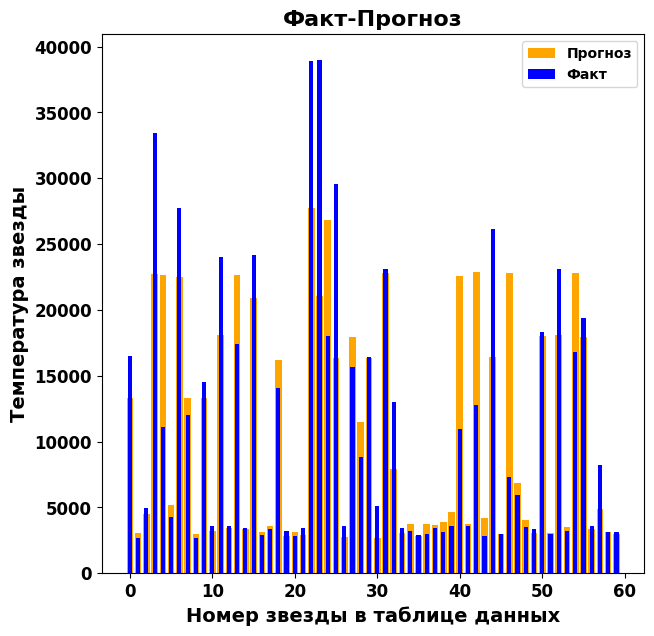

In [47]:
# Создание графика "Факт-Прогноз" по полученным результатам нейросети
show_graph(batch_nn_preds)

**Вывод по промежуточному этапу**

При использовании метода обучения нейронной сети через регуляризацию размера батчей, а также при изменении количества эпох обучения удалось улучшить значение метрики RMSE на тестовом наборе данных при прогнозировании температуры звезд:

**С 7 064 до 5 375 К**

#### Метод Batch Normalization <a class = 'anchor' id = 'Моделирование_улучшение_BatchNorm'></a>

In [48]:
#  Создание улучшенной нейросети с нормализацией батчей
class BatchImprovedNeuralNet(nn.Module):
    def __init__(self, in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons):
        super(BatchImprovedNeuralNet, self).__init__()
        self.fc1 = nn.Linear(in_neurons, hidden_neurons_1)
        self.batch1 = nn.BatchNorm1d(hidden_neurons_1)
        self.ac1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)
        self.batch2 = nn.BatchNorm1d(hidden_neurons_2)
        self.ac2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(hidden_neurons_2, out_neurons)
        self.batch3 = nn.BatchNorm1d(out_neurons)
        self.ac3 = nn.LeakyReLU()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.batch1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.batch2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        x = self.batch3(x)
        x = self.ac3(x)
        return x


# Инициализация модели, весов и оптимизатора
net = BatchImprovedNeuralNet(n_in_neurons,
                             n_hidden_neurons_1,
                             n_hidden_neurons_2,
                             n_out_neurons)
net.apply(init_weights)
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3)

# Релизация обучения с помощью батчей
batch_norm_nn_preds = batch_training(epochs_num = 10_001, epoch_test = 500)

Epoch #: 0
RMSE = 14626.5830078125 

Epoch #: 500
RMSE = 8704.345703125 

Epoch #: 1000
RMSE = 7322.72119140625 

Epoch #: 1500
RMSE = 6698.02099609375 

Epoch #: 2000
RMSE = 5924.3515625 

Epoch #: 2500
RMSE = 5573.77587890625 

Epoch #: 3000
RMSE = 5426.826171875 

Epoch #: 3500
RMSE = 5376.52099609375 

Epoch #: 4000
RMSE = 5269.59375 

Epoch #: 4500
RMSE = 5105.3447265625 

Epoch #: 5000
RMSE = 4985.73291015625 

Epoch #: 5500
RMSE = 4839.18017578125 

Epoch #: 6000
RMSE = 4793.49951171875 

Epoch #: 6500
RMSE = 4793.84326171875 

Epoch #: 7000
RMSE = 4826.0224609375 

Epoch #: 7500
RMSE = 4898.64404296875 

Epoch #: 8000
RMSE = 4982.962890625 

Epoch #: 8500
RMSE = 5056.14794921875 

Epoch #: 9000
RMSE = 5125.05712890625 

Epoch #: 9500
RMSE = 5229.21630859375 

Epoch #: 10000
RMSE = 5340.0068359375 



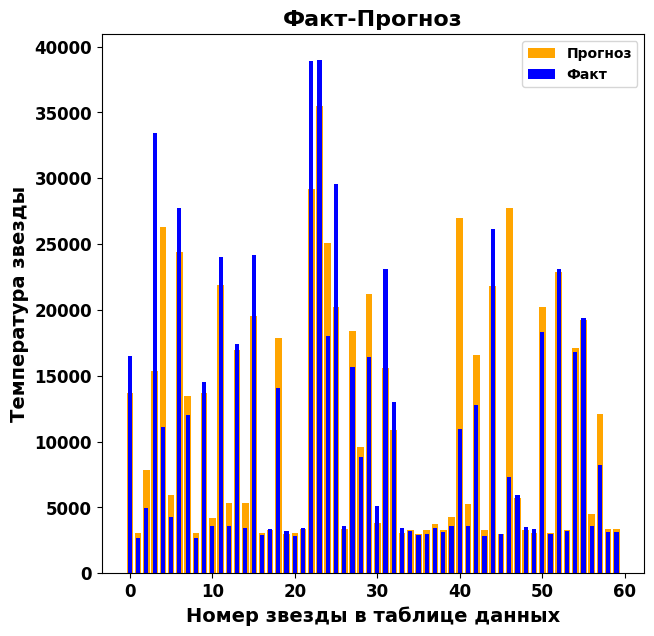

In [49]:
# Создание графика "Факт-Прогноз" по полученным результатам нейросети
show_graph(batch_norm_nn_preds)

**Вывод по промежуточному этапу**

При использовании метода Batch Normalization улучшения нейронной сети, а также при изменении количества эпох обучения удалось улучшить значение метрики RMSE на тестовом наборе данных при прогнозировании температуры звезд:

**С 7 064 К** на baseline-модели до **4 125 К** на текущей версии.

При такой модификации модели нейронной сети **удалось пройти требуемый порог в 4 500 К**.

#### Метод Dropout <a class = 'anchor' id = 'Моделирование_улучшение_dropout'></a>

In [50]:
# Создание класса нейронной сети с Dropout ("выключением" нейронов)
class DropoutNeuralNet(nn.Module):
    def __init__(self, in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons):
        super(DropoutNeuralNet, self).__init__()
        self.fc1 = nn.Linear(in_neurons, hidden_neurons_1)
        self.drop1 = nn.Dropout(p=0.6)
        self.ac1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)
        self.drop2 = nn.Dropout(p=0.6)
        self.ac2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(hidden_neurons_2, out_neurons)
        self.ac3 = nn.LeakyReLU()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.drop1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        x = self.ac3(x)
        return x


# Инициализация модели, весов, оптимизатора
net = DropoutNeuralNet(n_in_neurons,
                       n_hidden_neurons_1,
                       n_hidden_neurons_2,
                       n_out_neurons)
net.apply(init_weights)
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3)

dropout_nn_preds = batch_training(epochs_num = 15001, epoch_test = 1000)

Epoch #: 0
RMSE = 14626.849609375 

Epoch #: 1000
RMSE = 13750.9072265625 

Epoch #: 2000
RMSE = 10836.326171875 

Epoch #: 3000
RMSE = 9093.28125 

Epoch #: 4000
RMSE = 8394.236328125 

Epoch #: 5000
RMSE = 7744.9208984375 

Epoch #: 6000
RMSE = 7423.2255859375 

Epoch #: 7000
RMSE = 7165.0322265625 

Epoch #: 8000
RMSE = 6916.85693359375 

Epoch #: 9000
RMSE = 6658.03466796875 

Epoch #: 10000
RMSE = 6394.1552734375 

Epoch #: 11000
RMSE = 6141.41748046875 

Epoch #: 12000
RMSE = 5913.546875 

Epoch #: 13000
RMSE = 5709.87158203125 

Epoch #: 14000
RMSE = 5546.15234375 

Epoch #: 15000
RMSE = 5450.60888671875 



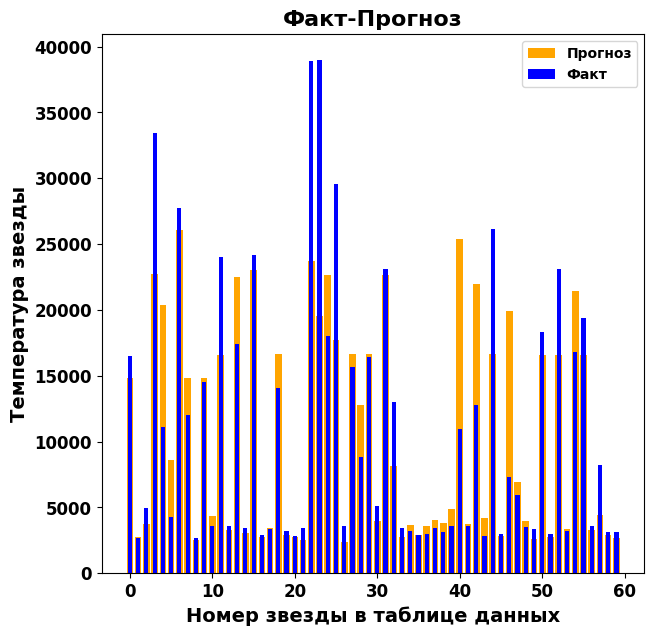

In [51]:
# Создание графика "Факт-Прогноз" по полученным результатам нейросети
show_graph(dropout_nn_preds)

**Вывод по промежуточному этапу**

При использовании метода Dropout улучшения нейронной сети, а также при изменении количества эпох обучения удалось улучшить значение метрики RMSE на тестовом наборе данных при прогнозировании температуры звезд:

**С 7 064 К** на baseline-модели до **5 364 К** на текущей версии.

При такой модификации модели нейронной сети **не удалось пройти требуемый порог в 4 500 К**.

**Вывод**

1. Проведено улучшение модели нейронной сети через **использование батчей**:
    * Достигнут показатель RMSE на тестовой выборке - **5 375 К**.
2. Проведено улучшение модели нейронной сети через **использование метода Batch Normalization**:
    * Достигнут показатель RMSE на тестовой выборке - **4 125 К**.
3. Проведено улучшение модели нейронной сети через **использование метода DropOut**:
    * Достигнут показатель RMSE на тестовой выборке - **5 364 К**.

## Общий вывод <a class = 'anchor' id = 'Вывод'></a>

**Вывод**

1. Импортированы библиотеки Python:
    * для манипулирования данными:
        * pandas;
        * numpy.
    * для визуализации данных:
        * matplotlib.pyplot;
        * seaborn;
        * plotly;
        * dash.
    * для вычисления корреляции данных:
        * phik_matrix.
    * для решения задач машинного обучения:
        * механизмы построения нейронной сети:
            * torch.nn.
        * метрики оценки эффективности моделей классификации;
        * train_test_split - механизм разделения данных;
        * StandardScaler - стандартизация данных;
        * OneHotEncoder - one-hot кодирование категориальных признаков;
        * OrdinalEncoder - кодирование значений ранговых признаков.
2. Инициализированы переменные **RANDOM_STATE** и **TEST_SIZE** для фиксирования "случайности" и размера тестовой выборки.
3. Произведена загрузка данных в рабочую среду Jupyter Notebook. Инициализирована переменная **stars**;
4. Выведены на экран параметры датасета:
    * В наборе данных **отсутствуют пустые значения** по признакам;
    * Типы данных **соответствуют сущностям значений** по всем рассматриваемым признакам;
    * Названия столбцов **необходимо привести к формату snake_case**;
    * Наблюдаются неявные дубликаты по признаку **Star color**;
    * Наблюдаются выбросы по количественным признакам:
        * **Temperature (K)**;
        * **Luminosity (L/Lo)**;
        * **Radius (R/Ro)**.
    * Самые популярные категории по спектральному классу: **M, B** и **O**;
    * Самые популярные цвета звезд: **Red**, **Pale yellow orange** и **Blue**.
5. Названия столбцов приведены к формату snake_case;
6. Обработаны неявные дубликаты - значения - по признаку **Star color**:
    * Понижен регистр значений;
    * Удалены пробелы в конце строк;
    * Заменены пробелы на дефис;
    * Заменены значения с перестановкой цвета.
7. Проверка датасетов на явные дубликаты - **Явные дубликаты отсутствуют**;
8. Набор `stars` характеризуется следующими статистическими показателями:
    * **temperature - температура звезды в Кельвинах**:
        * Среднее значение - 10 497.5;
        * Минимальное значение - 1 939.0;
        * Максимальное значение - 40 000.0;
        * Стандартное отклонение - 9 552.4.
    * **luminosity - относительная светимость**:
        * Среднее значение - 107 188.4;
        * Минимальное значение - 0.0;
        * Максимальное значение - 849 420.0.
        * Стандартное отклонение - 179 432.2.
    * **radius - относительный радиус**:
        * Среднее значение - 237.2;
        * Минимальное значение - 0.0084;
        * Максимальное значение - 1 948.5;
        * Стандартное отклонение - 517.2.
    * **absolute_magnitude - абсолютная звездная величина**:
        * Среднее значение - 4.4;
        * Минимальное значение - -11.9;
        * Максимальное значение - 20.1;
        * Стандартное отклонение - 10.5.
9. Произведен анализ категориальных данных:
    * Большая часть звезд (87%) представлена тремя основными цветами: **red** (47%), **blue** (23%) и **blue-white** (17%);
    * Все звезды распределены в равном отношении друг к другу: **40 представителей в каждом из 6 типов**.
10. Проведен анализ количественных признаков:
    * Анализ признака **temperature**:
        * **Высокие температуры характерны для звезд типа 2, 3 и 4** (Белый карлик, Звезды главной последовательности и Сверхгиганты, соответственно);
        * **Наличие среди этих объектов звезды типа 5 - Сверхгигант - является уникальной ситуацией, но не подлежащей исключению из набора**.
    * Анализ признака **luminosity**:
        * Объекты с аномально большой светимостью относятся к типу 4 и 5 - **Сверхгиганты и Гипергиганты, соответственно**.
        * **Очистки набора данных от аномальных значений по данному признаку не требуется**.
    * Анализ признака **radius**:
        * Объекты с аномально большими радиусами относительно Солнца относятся к типу 5 - **Гипергиганты**;
        * **Очистки набора данных от аномальных значений по данному признаку не требуется**.
    * Анализ признака **absolute_magnitude**:
        * Наблюдается **бимодальное распределение значений**, находящееся в пределах допустимых границ.
        * **Очистки набора данных от аномальных значений по данному признаку не требуется**.
11. Инициализирована пользовательской функция - **data_preparing** - подготовки данных, в которой выполняется:
    * Разделение исходного набора `stars` на область признаков и вектор целевой переменной - инициализация переменных `X` и **y** соответственно;
    * Инициализация переменных `X_train`, `X_test`, **y_train** и **y_test** для хранения обучающих и тестовых наборов данных;
    * Масштабирование количественных значений стратегией стандартизации;
    * Кодирование категориальных значений стратегиями OneHotEncoding и OrdinalEncoding;
    * Объединение обработанных значений в общие наборы данных - перезапись переменных `X_train` и `X_test`;
12. Произведен отбор категориальных и количественных значений в отдельные переменные - инициализированы переменные **ohe_cols**, **ord_cols** и **num_cols**;
13. Выполнено преобразование исходного набора данных;
14. Введены переменные для задания констант, формирующих нейронную сеть:
    * Количество скрытых слоев - **2**;
    * Количество нейронов:
        * На входном слое - **равно количеству признаков модели**;
        * На 1 скрытом слое - **8**;
        * На 2 скрыто слое - **5**;
        * На выходном слое - **1**.
    * Функции активации на скрытых и выходном слоях - **LeakyReLU**;
15. Создан класс для задания архитектуры нейронной сети;
16. Инициализированы пользовательские функции обучения / тестирования модели;
17. Инициализированы пользовательские функции построения графика прогноз / факт;
18. Инициализированы пользовательские функции генерации весов;
19. Преобразованы входные данные в тензоры PyTorch;
20. Проведены обучение нейронной сети и проверка качества прогнозов на тестовой выборке:
    * **На эпохе под номером 9 000 метрика RMSE составляет - 7 064**.
21. Проведено улучшение модели нейронной сети через **использование батчей**:
    * Достигнут показатель RMSE на тестовой выборке - **5 375 К**.
22. Проведено улучшение модели нейронной сети через **использование метода Batch Normalization**:
    * Достигнут показатель RMSE на тестовой выборке - **4 125 К**.
23. Проведено улучшение модели нейронной сети через **использование метода DropOut**:
    * Достигнут показатель RMSE на тестовой выборке - **5 364 К**.